# Your First GAN

### Goal
In this notebook, you're going to create your first generative adversarial network (GAN) for this course! Specifically, you will build and train a GAN that can generate hand-written images of digits (0-9). You will be using PyTorch in this specialization, so if you're not familiar with this framework, you may find the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) useful. The hints will also often include links to relevant documentation.

### Learning Objectives
1.   Build the generator and discriminator components of a GAN from scratch.
2.   Create generator and discriminator loss functions.
3.   Train your GAN and visualize the generated images.


## Getting Started
You will begin by importing some useful packages and the dataset you will use to build and train your GAN. You are also provided with a visualizer function to help you investigate the images your GAN will create.


In [1]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images your discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28! The small size of its images makes MNIST ideal for simple training. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them (more on this later in the course).

#### Tensor
You will represent the data using [tensors](https://pytorch.org/docs/stable/tensors.html). Tensors are a generalization of matrices: for example, a stack of three matrices with the amounts of red, green, and blue at different locations in a 64 x 64 pixel image is a tensor with the shape 3 x 64 x 64.

Tensors are easy to manipulate and supported by [PyTorch](https://pytorch.org/), the machine learning library you will be using. Feel free to explore them more, but you can imagine these as multi-dimensional matrices or vectors!

#### Batches
While you could train your model after generating one image, it is extremely inefficient and leads to less stable training. In GANs, and in machine learning in general, you will process multiple images per training step. These are called batches.

This means that your generator will generate an entire batch of images and receive the discriminator's feedback on each before updating the model. The same goes for the discriminator, it will calculate its loss on the entire batch of generated images as well as on the reals before the model is updated.

## Generator
The first step is to build the generator component.

You will start by creating a function to make a single layer/block for the generator's neural network. Each block should include a [linear transformation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to map to another shape, a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for stabilization, and finally a non-linear activation function (you use a [ReLU here](https://pytorch.org/docs/master/generated/torch.nn.ReLU.html)) so the output can be transformed in complex ways. You will learn more about activations and batch normalization later in the course.

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_generator_block
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        # Hint: Replace all of the "None" with the appropriate dimensions.
        # The documentation may be useful if you're less familiar with PyTorch:
        # https://pytorch.org/docs/stable/nn.html.
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
        #### END CODE HERE ####
    )

In [3]:
# Verify the generator block function
def test_gen_block(in_features, out_features, num_test=1000):
    block = get_generator_block(in_features, out_features)

    # Check the three parts
    assert len(block) == 3
    assert type(block[0]) == nn.Linear
    assert type(block[1]) == nn.BatchNorm1d
    assert type(block[2]) == nn.ReLU
    
    # Check the output shape
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)
    assert tuple(test_output.shape) == (num_test, out_features)
    assert test_output.std() > 0.55
    assert test_output.std() < 0.65

test_gen_block(25, 12)
test_gen_block(15, 28)
print("Success!")

Success!


Now you can build the generator class. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). You will need to fill in the code for final layer since it is different than the others. The final layer does not need a normalization or activation function, but does need to be scaled with a [sigmoid function](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html). 

Finally, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">Generator</font></code></b>
</font>
</summary>

1. The output size of the final linear transformation should be im_dim, but remember you need to scale the outputs between 0 and 1 using the sigmoid function.
2. [nn.Linear](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) and [nn.Sigmoid](https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html) will be useful here. 
</details>


In [4]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [5]:
# Verify the generator class
def test_generator(z_dim, im_dim, hidden_dim, num_test=10000):
    gen = Generator(z_dim, im_dim, hidden_dim).get_gen()
    
    # Check there are six modules in the sequential part
    assert len(gen) == 6
    test_input = torch.randn(num_test, z_dim)
    test_output = gen(test_input)

    # Check that the output shape is correct
    
    assert tuple(test_output.shape) == (num_test, im_dim)
    assert test_output.max() < 1, "Make sure to use a sigmoid"
    assert test_output.min() > 0, "Make sure to use a sigmoid"
    assert test_output.std() > 0.05, "Don't use batchnorm here"
    assert test_output.std() < 0.15, "Don't use batchnorm here"

test_generator(5, 10, 20)
test_generator(20, 8, 24)
print("Success!")

Success!


## Noise
To be able to use your generator, you will need to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same -- think of it as a random seed. You will generate it randomly using PyTorch by sampling random numbers from the normal distribution. Since multiple images will be processed per pass, you will generate all the noise vectors at once.

Note that whenever you create a new tensor using torch.ones, torch.zeros, or torch.randn, you either need to create it on the target device, e.g. `torch.ones(3, 3, device=device)`, or move it onto the target device using `torch.ones(3, 3).to(device)`. You do not need to do this if you're creating a tensor by manipulating another tensor or by using a variation that defaults the device to the input, such as `torch.ones_like`. In general, use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros` where possible.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">get_noise</font></code></b>
</font>
</summary>

1. 
You will probably find [torch.randn](https://pytorch.org/docs/master/generated/torch.randn.html) useful here.
</details>

In [6]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_noise
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    #### START CODE HERE ####
    return torch.randn(n_samples, z_dim, device=device)
    #### END CODE HERE ####

In [7]:
# Verify the noise vector function
def test_get_noise(n_samples, z_dim, device='cpu'):
    noise = get_noise(n_samples, z_dim, device)
    
    # Make sure a normal distribution was used
    assert tuple(noise.shape) == (n_samples, z_dim)
    assert torch.abs(noise.std() - torch.tensor(1.0)) < 0.01
    assert str(noise.device).startswith(device)

test_get_noise(1000, 100, 'cpu')
if torch.cuda.is_available():
    test_get_noise(1000, 32, 'cuda')
print("Success!")

Success!


## Discriminator
The second component that you need to construct is the discriminator. As with the generator component, you will start by creating a function that builds a neural network block for the discriminator.

*Note: You use leaky ReLUs to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient. You will learn more about this in the following lectures!* 


REctified Linear Unit (ReLU) |  Leaky ReLU
:-------------------------:|:-------------------------:
![](relu-graph.png)  |  ![](lrelu-graph.png)





In [8]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
        #### END CODE HERE ####
    )

In [9]:
# Verify the discriminator block function
def test_disc_block(in_features, out_features, num_test=10000):
    block = get_discriminator_block(in_features, out_features)

    # Check there are two parts
    assert len(block) == 2
    test_input = torch.randn(num_test, in_features)
    test_output = block(test_input)

    # Check that the shape is right
    assert tuple(test_output.shape) == (num_test, out_features)
    
    # Check that the LeakyReLU slope is about 0.2
    assert -test_output.min() / test_output.max() > 0.1
    assert -test_output.min() / test_output.max() < 0.3
    assert test_output.std() > 0.3
    assert test_output.std() < 0.5

test_disc_block(25, 12)
test_disc_block(15, 28)
print("Success!")

Success!


Now you can use these blocks to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that you do not need a sigmoid after the output layer since it is included in the loss function. Finally, to use your discrimator's neural network you are given a forward pass function that takes in an image tensor to be classified.


In [10]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 8),
            get_discriminator_block(hidden_dim * 8, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [12]:
# Verify the discriminator class
def test_discriminator(z_dim, hidden_dim, num_test=100):
    
    disc = Discriminator(z_dim, hidden_dim).get_disc()

    # Check there are three parts
#     assert len(disc) == 4

    # Check the linear layer is correct
    test_input = torch.randn(num_test, z_dim)
    test_output = disc(test_input)
    assert tuple(test_output.shape) == (num_test, 1)
    
    # Make sure there's no sigmoid
    assert test_input.max() > 1
    assert test_input.min() < -1

test_discriminator(5, 10)
test_discriminator(20, 8)
print("Success!")

Success!


## Training
Now you can put it all together!
First, you will set your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU

Next, you will load the MNIST dataset as tensors using a dataloader.



In [13]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cuda:2'

Now, you can initialize your generator, discriminator, and optimizers. Note that each optimizer only takes the parameters of one particular model, since we want each optimizer to optimize only one of the models.

In [14]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call .detach() on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [15]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     Note: Please do not use concatenation in your solution. The tests are being updated to 
    #           support this, but for now, average the two losses as described in step (4).
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake = gen(noise).detach()
    pred_fake = disc(fake)
    true_fake = torch.zeros_like(pred_fake)
    fake_loss = criterion(pred_fake, true_fake)
    
    pred_real = disc(real)
    true_real = torch.ones_like(pred_real)
    real_loss = criterion(pred_real, true_real)
    
    disc_loss = (fake_loss + real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [16]:
def test_disc_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_disc_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = lambda x: x.mean(1)[:, None]
    criterion = torch.mul # Multiply
    real = torch.ones(num_images, z_dim)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(disc_loss.mean() - 0.5) < 1e-5)
    
    gen = torch.ones_like
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, z_dim)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu')) < 1e-5)
    
    gen = lambda x: torch.ones(num_images, 10)
    disc = lambda x: x.mean(1)[:, None] + 10
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 10)
    assert torch.all(torch.abs(get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean() - 5) < 1e-5)

    gen = torch.ones_like
    disc = nn.Linear(64, 1, bias=False)
    real = torch.ones(num_images, 64) * 0.5
    disc.weight.data = torch.ones_like(disc.weight.data) * 0.5
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    criterion = lambda x, y: torch.sum(x) + torch.sum(y)
    disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cpu').mean()
    disc_loss.backward()
    assert torch.isclose(torch.abs(disc.weight.grad.mean() - 11.25), torch.tensor(3.75))
    
def test_disc_loss(max_tests = 10):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    num_steps = 0
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradient before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        assert (disc_loss - 0.68).abs() < 0.05

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Check that they detached correctly
        assert gen.gen[0][0].weight.grad is None

        # Update optimizer
        old_weight = disc.disc[0][0].weight.data.clone()
        disc_opt.step()
        new_weight = disc.disc[0][0].weight.data
        
        # Check that some discriminator weights changed
        assert not torch.all(torch.eq(old_weight, new_weight))
        num_steps += 1
        if num_steps >= max_tests:
            break

test_disc_reasonable()
test_disc_loss()
print("Success!")

Success!


In [17]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    noise = get_noise(num_images, z_dim, device)
    fake = gen(noise)
    pred_fake = disc(fake)
    true_fake = torch.ones_like(pred_fake)
    gen_loss = criterion(pred_fake, true_fake)
    #### END CODE HERE ####
    return gen_loss

In [18]:
def test_gen_reasonable(num_images=10):
    # Don't use explicit casts to cuda - use the device argument
    import inspect, re
    lines = inspect.getsource(get_gen_loss)
    assert (re.search(r"to\(.cuda.\)", lines)) is None
    assert (re.search(r"\.cuda\(\)", lines)) is None
    
    z_dim = 64
    gen = torch.zeros_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)

    gen = torch.ones_like
    disc = nn.Identity()
    criterion = torch.mul # Multiply
    real = torch.zeros(num_images, 1)
    gen_loss_tensor = get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cpu')
    assert torch.all(torch.abs(gen_loss_tensor - 1) < 1e-5)
    #Verify shape. Related to gen_noise parametrization
    assert tuple(gen_loss_tensor.shape) == (num_images, z_dim)
    

def test_gen_loss(num_images):
    z_dim = 64
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    disc = Discriminator().to(device) 
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
    
    gen_loss = get_gen_loss(gen, disc, criterion, num_images, z_dim, device)
    
    # Check that the loss is reasonable
    assert (gen_loss - 0.7).abs() < 0.1
    gen_loss.backward()
    old_weight = gen.gen[0][0].weight.clone()
    gen_opt.step()
    new_weight = gen.gen[0][0].weight
    assert not torch.all(torch.eq(old_weight, new_weight))


test_gen_reasonable(10)
test_gen_loss(18)
print("Success!")

Success!


Finally, you can put everything together! For each epoch, you will process the entire dataset in batches. For every batch, you will need to update the discriminator and generator using their loss. Batches are sets of images that will be predicted on before the loss functions are calculated (instead of calculating the loss function after each image). Note that you may see a loss to be greater than 1, this is okay since binary cross entropy loss can be any positive number for a sufficiently confident wrong guess. 

It’s also often the case that the discriminator will outperform the generator, especially at the start, because its job is easier. It's important that neither one gets too good (that is, near-perfect accuracy), which would cause the entire model to stop learning. Balancing the two models is actually remarkably hard to do in a standard GAN and something you will see more of in later lectures and assignments.

After you've submitted a working version with the original architecture, feel free to play around with the architecture if you want to see how different architectural choices can lead to better or worse GANs. For example, consider changing the size of the hidden dimension, or making the networks shallower or deeper by changing the number of layers.

<!-- In addition, be warned that this runs very slowly on a CPU. One way to run this more quickly is to use Google Colab: 

1.   Download the .ipynb
2.   Upload it to Google Drive and open it with Google Colab
3.   Make the runtime type GPU (under “Runtime” -> “Change runtime type” -> Select “GPU” from the dropdown)
4.   Replace `device = "cpu"` with `device = "cuda"`
5.   Make sure your `get_noise` function uses the right device -->

But remember, don’t expect anything spectacular: this is only the first lesson. The results will get better with later lessons as you learn methods to help keep your generator and discriminator at similar levels.

You should roughly expect to see this progression. On a GPU, this should take about 15 seconds per 500 steps, on average, while on CPU it will take roughly 1.5 minutes:
![MNIST Digits](MNIST_Progression.png)

  7%|▋         | 31/469 [00:00<00:09, 45.48it/s]

Epoch 1, step 500: Generator loss: 3.7169503210783006, discriminator loss: 0.21535132020711892


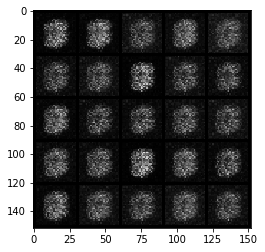

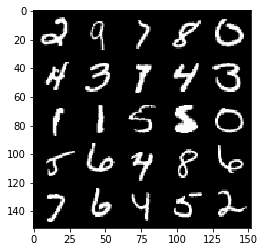

 13%|█▎        | 59/469 [00:01<00:09, 44.53it/s]

Epoch 2, step 1000: Generator loss: 4.841527026176455, discriminator loss: 0.04279312375001617


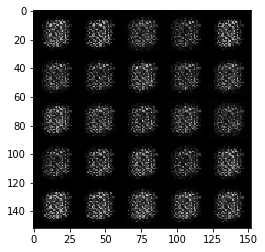

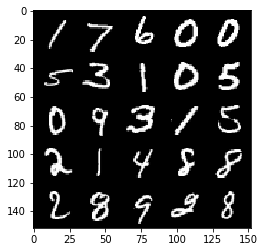

 19%|█▉        | 91/469 [00:02<00:08, 42.03it/s]

Epoch 3, step 1500: Generator loss: 5.257012383461001, discriminator loss: 0.01413247217703611


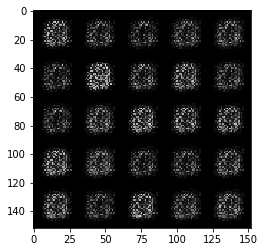

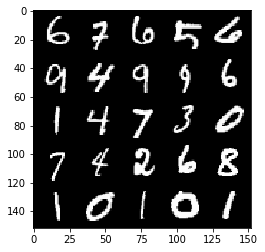

 26%|██▋       | 124/469 [00:02<00:05, 60.31it/s]

Epoch 4, step 2000: Generator loss: 6.610397219657896, discriminator loss: 0.009369897774304277


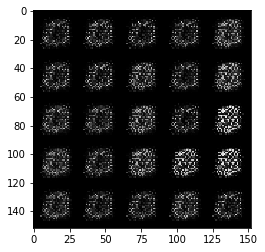

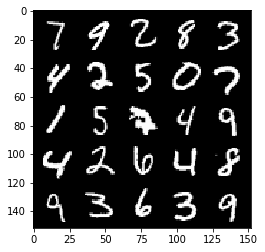

 33%|███▎      | 155/469 [00:03<00:07, 42.74it/s]

Epoch 5, step 2500: Generator loss: 8.437996706962583, discriminator loss: 0.005334396184887735


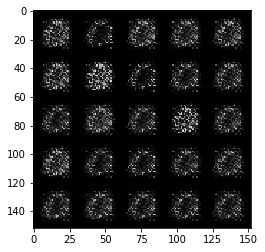

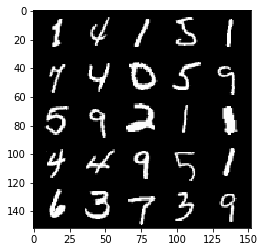

 39%|███▉      | 183/469 [00:04<00:06, 42.58it/s]

Epoch 6, step 3000: Generator loss: 8.439075545310972, discriminator loss: 0.005141494790615975


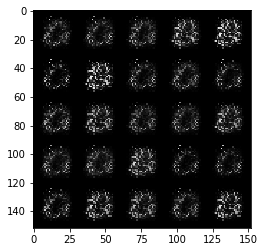

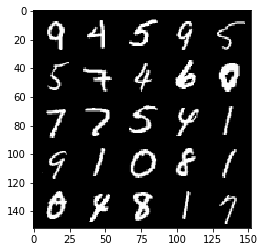

 46%|████▋     | 217/469 [00:03<00:04, 60.82it/s]

Epoch 7, step 3500: Generator loss: 7.80381477928162, discriminator loss: 0.005206489832489751


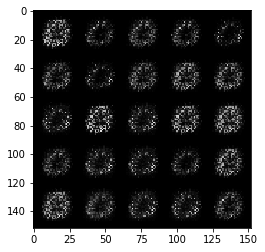

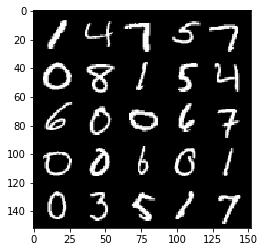

 52%|█████▏    | 243/469 [00:04<00:03, 60.56it/s]

Epoch 8, step 4000: Generator loss: 7.7937056646347145, discriminator loss: 0.004535742165637199


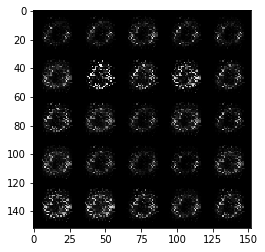

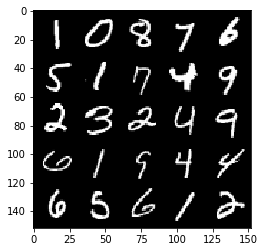

 59%|█████▉    | 278/469 [00:04<00:03, 60.69it/s]

Epoch 9, step 4500: Generator loss: 8.61362921619417, discriminator loss: 0.0036343477826449085


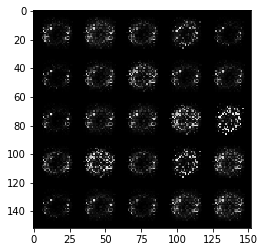

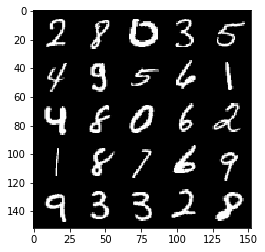

 66%|██████▌   | 308/469 [00:05<00:03, 43.62it/s]

Epoch 10, step 5000: Generator loss: 7.752125726699832, discriminator loss: 0.0029581365199410365


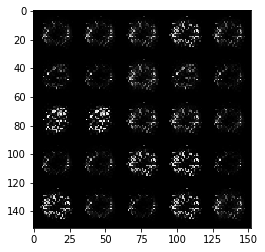

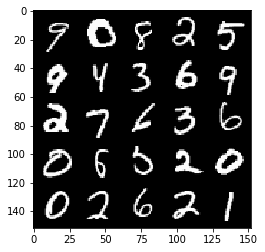

 73%|███████▎  | 341/469 [00:07<00:03, 42.50it/s]

Epoch 11, step 5500: Generator loss: 7.84342159938812, discriminator loss: 0.0026282938087242667


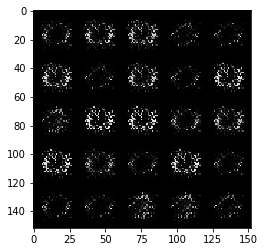

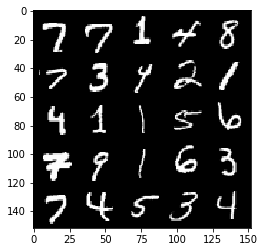

 79%|███████▉  | 370/469 [00:08<00:02, 41.94it/s]

Epoch 12, step 6000: Generator loss: 10.170139154434201, discriminator loss: 0.00356808938413451


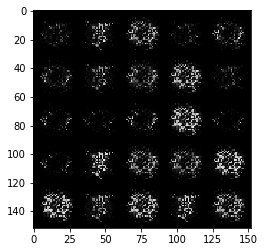

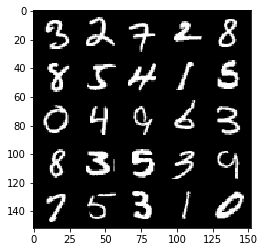

 86%|████████▌ | 402/469 [00:09<00:01, 42.14it/s]

Epoch 13, step 6500: Generator loss: 8.760259743690481, discriminator loss: 0.005386335045914166


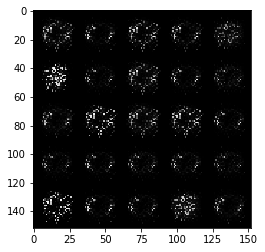

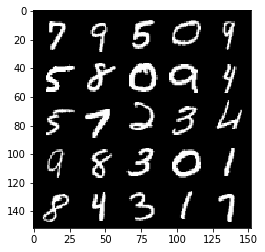

 92%|█████████▏| 432/469 [00:09<00:00, 44.25it/s]

Epoch 14, step 7000: Generator loss: 8.188216935157769, discriminator loss: 0.004579837086086628


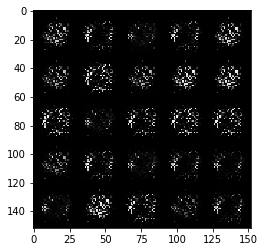

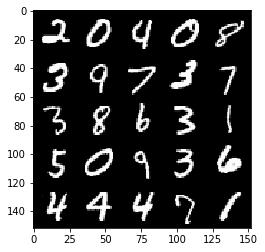

 99%|█████████▊| 462/469 [00:07<00:00, 60.79it/s]

Epoch 15, step 7500: Generator loss: 9.946748292922978, discriminator loss: 0.0029005425399227505


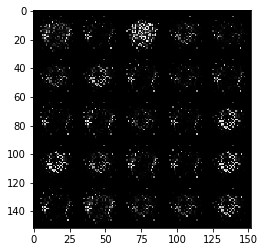

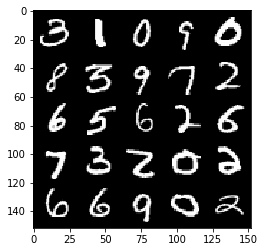

  6%|▌         | 26/469 [00:00<00:10, 43.64it/s]

Epoch 17, step 8000: Generator loss: 9.799930368423455, discriminator loss: 0.003000266782495599


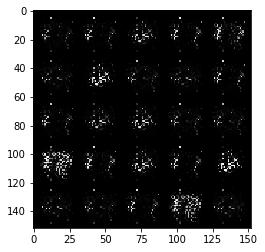

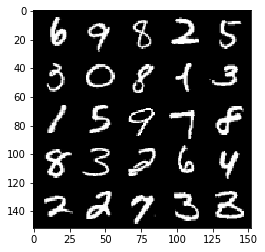

 12%|█▏        | 57/469 [00:01<00:08, 47.51it/s]

Epoch 18, step 8500: Generator loss: 8.863936917304986, discriminator loss: 0.00542876222592895


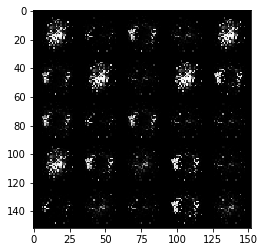

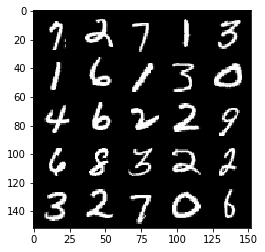

 18%|█▊        | 86/469 [00:01<00:08, 43.52it/s]

Epoch 19, step 9000: Generator loss: 8.757507943153376, discriminator loss: 0.004616410889168034


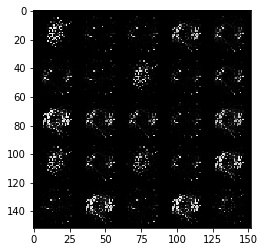

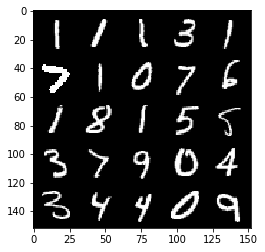

 25%|██▍       | 116/469 [00:01<00:05, 61.12it/s]

Epoch 20, step 9500: Generator loss: 8.974076033592215, discriminator loss: 0.0043195677603362105


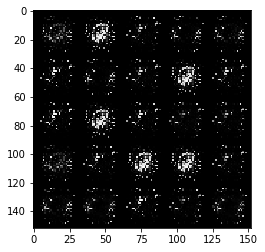

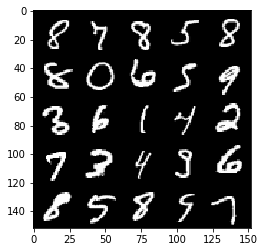

 31%|███▏      | 147/469 [00:02<00:05, 60.76it/s]

Epoch 21, step 10000: Generator loss: 8.686232983589177, discriminator loss: 0.0018924929354252546


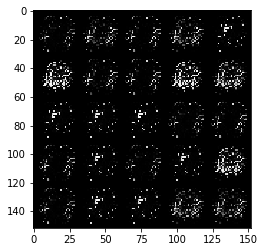

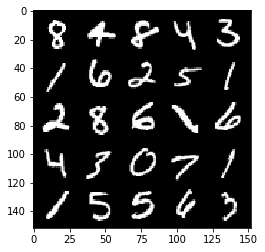

 38%|███▊      | 179/469 [00:03<00:06, 42.70it/s]

Epoch 22, step 10500: Generator loss: 10.647699949264533, discriminator loss: 0.0016637057678799466


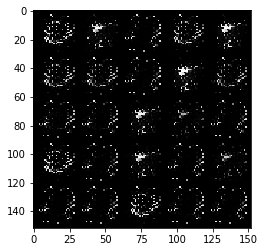

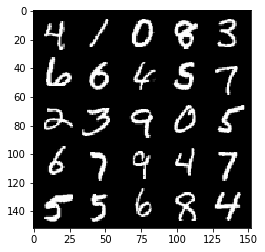

 45%|████▍     | 211/469 [00:04<00:06, 42.65it/s]

Epoch 23, step 11000: Generator loss: 11.02242750549316, discriminator loss: 0.004072831804614907


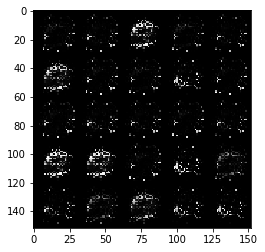

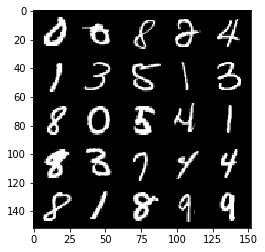

 51%|█████     | 240/469 [00:05<00:05, 42.71it/s]

Epoch 24, step 11500: Generator loss: 10.73490263748169, discriminator loss: 0.004293910568630958


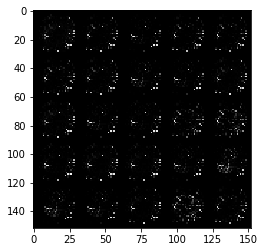

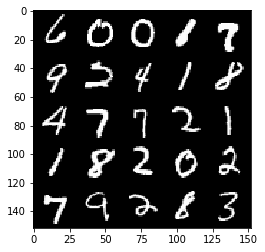

 58%|█████▊    | 272/469 [00:06<00:04, 41.58it/s]

Epoch 25, step 12000: Generator loss: 9.167729034423834, discriminator loss: 0.004021597338723956


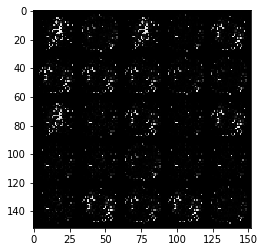

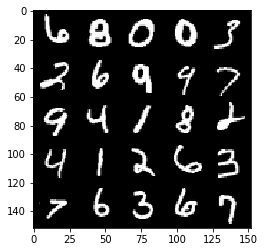

 64%|██████▍   | 302/469 [00:05<00:02, 60.58it/s]

Epoch 26, step 12500: Generator loss: 10.352545738220211, discriminator loss: 0.0024623150098559555


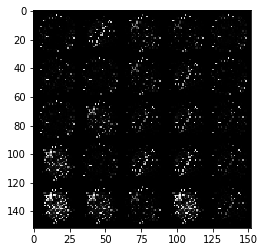

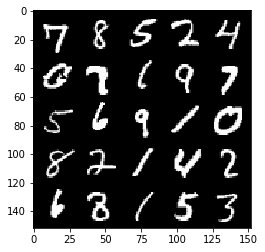

 71%|███████   | 334/469 [00:05<00:02, 60.48it/s]

Epoch 27, step 13000: Generator loss: 9.935787258148178, discriminator loss: 0.0021029528941435283


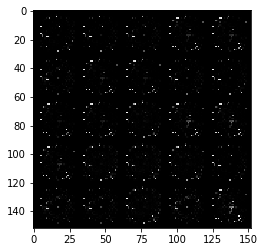

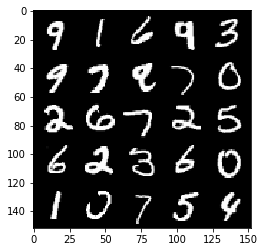

 77%|███████▋  | 362/469 [00:05<00:01, 60.20it/s]

Epoch 28, step 13500: Generator loss: 10.001939641952513, discriminator loss: 0.002154002241171839


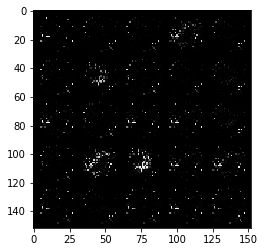

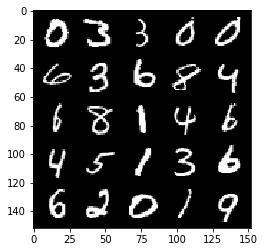

 85%|████████▍ | 397/469 [00:06<00:01, 60.93it/s]

Epoch 29, step 14000: Generator loss: 10.23968693161012, discriminator loss: 0.0018577800612638398


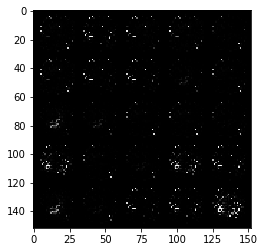

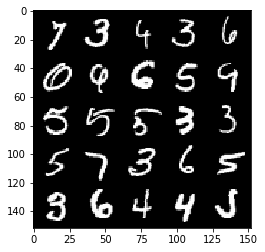

 91%|█████████ | 426/469 [00:07<00:00, 60.55it/s]

Epoch 30, step 14500: Generator loss: 9.396227558135978, discriminator loss: 0.0014113720338937137


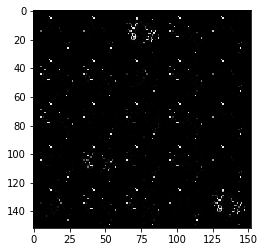

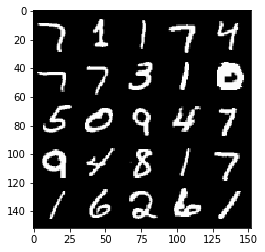

 98%|█████████▊| 461/469 [00:07<00:00, 60.38it/s]

Epoch 31, step 15000: Generator loss: 10.443189849853521, discriminator loss: 0.0018539614648962028


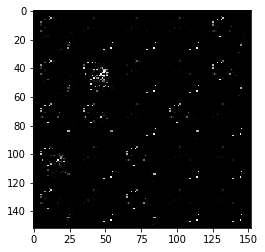

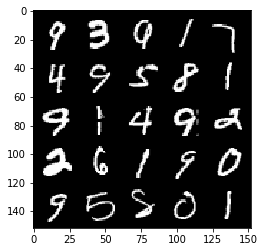

  5%|▍         | 23/469 [00:00<00:10, 40.89it/s]

Epoch 33, step 15500: Generator loss: 8.74729546165465, discriminator loss: 0.0006060692103492334


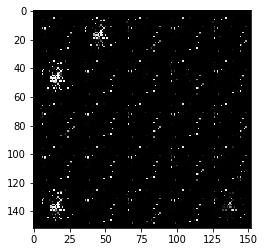

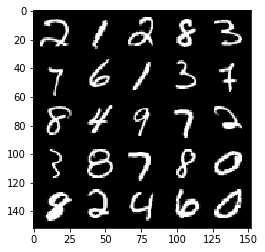

 11%|█         | 50/469 [00:01<00:08, 46.56it/s]

Epoch 34, step 16000: Generator loss: 12.415802944183346, discriminator loss: 0.0013715873835167252


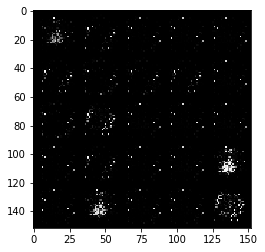

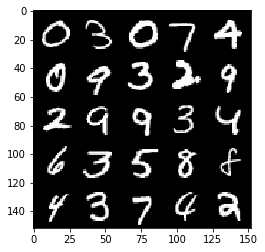

 18%|█▊        | 85/469 [00:01<00:06, 60.08it/s]

Epoch 35, step 16500: Generator loss: 11.419137559890746, discriminator loss: 0.0010929948689727108


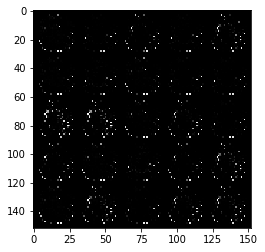

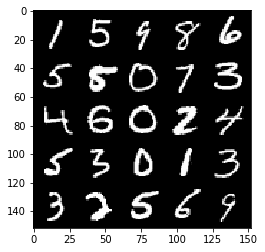

 24%|██▍       | 112/469 [00:02<00:07, 46.38it/s]

Epoch 36, step 17000: Generator loss: 10.662653652191157, discriminator loss: 0.0011499324249980428


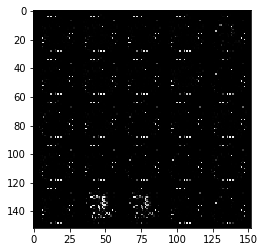

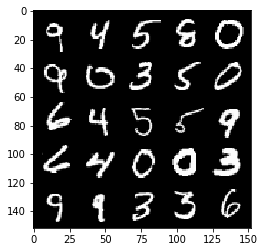

 31%|███       | 144/469 [00:02<00:05, 60.55it/s]

Epoch 37, step 17500: Generator loss: 10.105796394348145, discriminator loss: 0.0005406960939794775


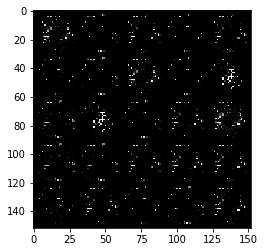

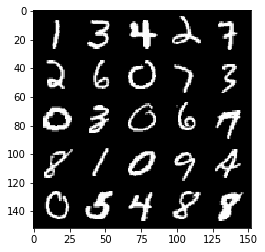

 37%|███▋      | 172/469 [00:02<00:04, 60.41it/s]

Epoch 38, step 18000: Generator loss: 12.304887704849245, discriminator loss: 0.001589310600514865


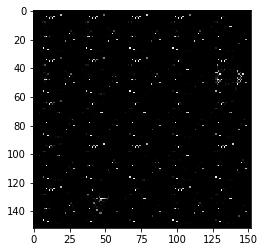

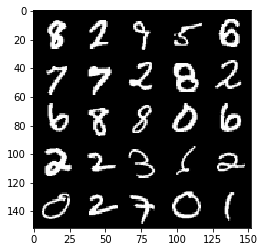

 44%|████▍     | 207/469 [00:03<00:04, 60.30it/s]

Epoch 39, step 18500: Generator loss: 12.110867248535147, discriminator loss: 0.0011001862187868029


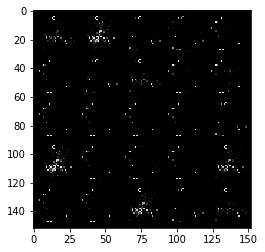

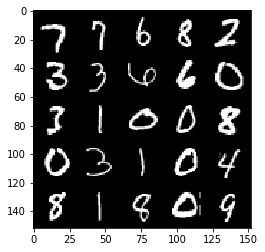

 51%|█████     | 237/469 [00:03<00:03, 60.85it/s]

Epoch 40, step 19000: Generator loss: 11.01726587486267, discriminator loss: 0.0015810177232360742


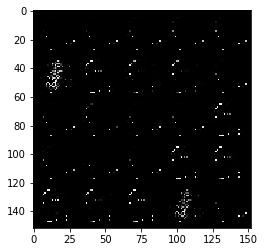

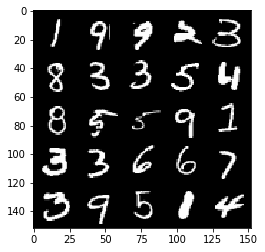

 57%|█████▋    | 268/469 [00:05<00:04, 46.57it/s]

Epoch 41, step 19500: Generator loss: 13.156126199722289, discriminator loss: 0.0023180792514576757


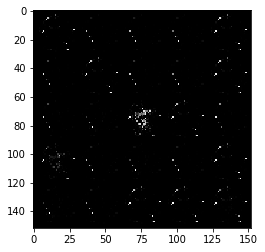

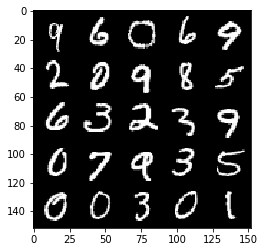

 64%|██████▍   | 301/469 [00:07<00:04, 41.76it/s]

Epoch 42, step 20000: Generator loss: 9.630640611648568, discriminator loss: 0.0005502140928811065


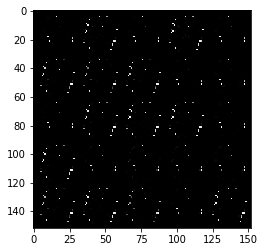

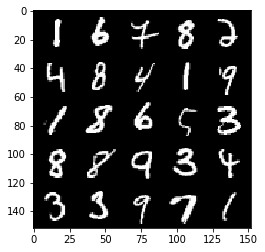

 71%|███████   | 333/469 [00:05<00:02, 60.55it/s]

Epoch 43, step 20500: Generator loss: 11.316712146759034, discriminator loss: 0.0008372900937467871


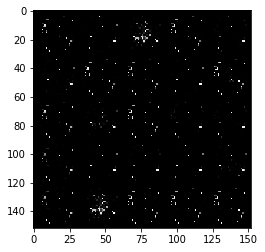

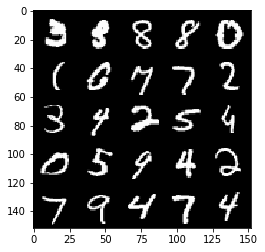

 77%|███████▋  | 362/469 [00:05<00:01, 60.59it/s]

Epoch 44, step 21000: Generator loss: 12.254838535308837, discriminator loss: 0.0009252778747713813


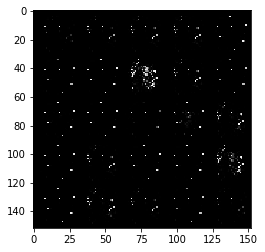

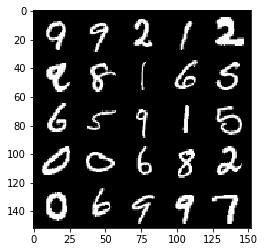

 83%|████████▎ | 389/469 [00:06<00:01, 60.56it/s]

Epoch 45, step 21500: Generator loss: 12.805772838592514, discriminator loss: 0.0019367192146933121


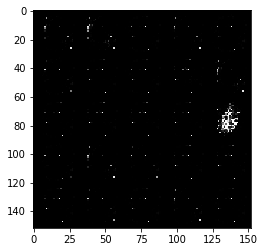

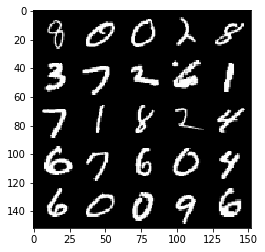

 91%|█████████ | 426/469 [00:07<00:00, 54.28it/s]

Epoch 46, step 22000: Generator loss: 10.449815433502186, discriminator loss: 0.003092472897335025


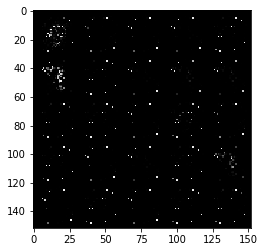

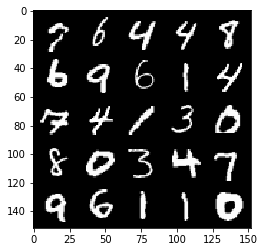

 97%|█████████▋| 453/469 [00:07<00:00, 60.62it/s]

Epoch 47, step 22500: Generator loss: 10.267191314697268, discriminator loss: 0.003594212892227011


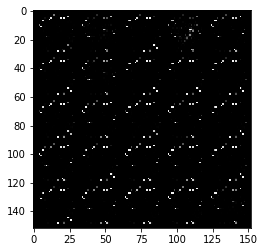

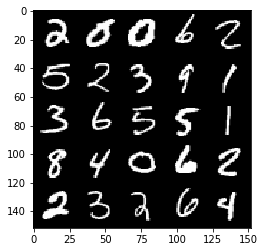

  4%|▍         | 19/469 [00:00<00:10, 44.34it/s]

Epoch 49, step 23000: Generator loss: 9.579934473037724, discriminator loss: 0.0007172811727650697


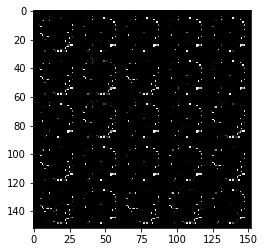

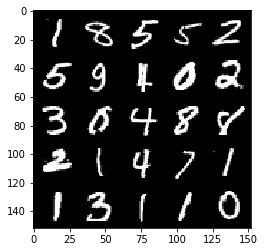

 10%|█         | 48/469 [00:00<00:07, 57.42it/s]

Epoch 50, step 23500: Generator loss: 13.191895494461063, discriminator loss: 0.0014456987171390671


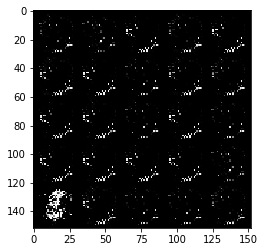

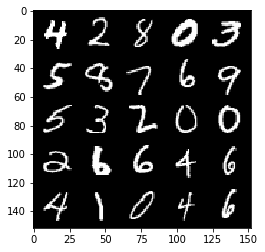

 16%|█▋        | 77/469 [00:01<00:06, 60.38it/s]

Epoch 51, step 24000: Generator loss: 14.341895381927486, discriminator loss: 0.0021764433900657424


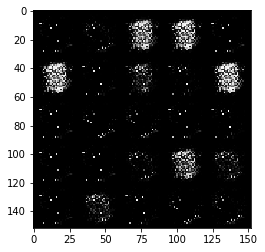

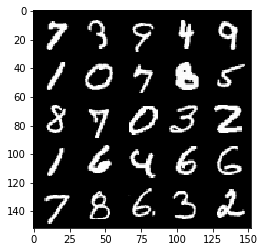

 23%|██▎       | 109/469 [00:02<00:07, 47.12it/s]

Epoch 52, step 24500: Generator loss: 11.992305257797243, discriminator loss: 0.002929200659903699


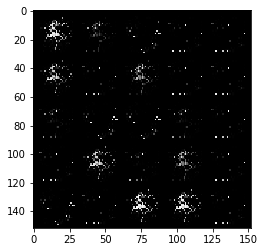

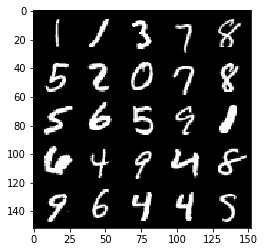

 30%|███       | 142/469 [00:02<00:05, 60.49it/s]

Epoch 53, step 25000: Generator loss: 10.696250478744506, discriminator loss: 0.0014119003018386149


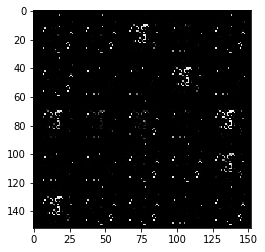

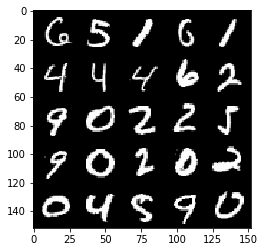

 36%|███▌      | 170/469 [00:03<00:07, 41.81it/s]

Epoch 54, step 25500: Generator loss: 10.891905809402468, discriminator loss: 0.0004972594400242096


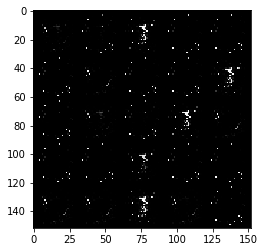

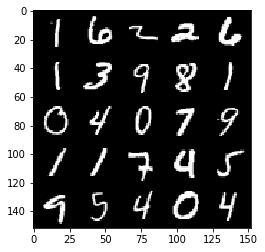

 44%|████▎     | 205/469 [00:04<00:06, 41.87it/s]

Epoch 55, step 26000: Generator loss: 11.957397529602055, discriminator loss: 0.0033656052862979778


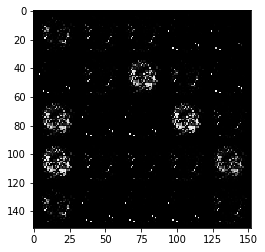

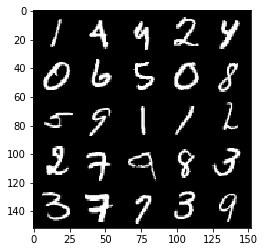

 50%|█████     | 236/469 [00:05<00:05, 42.93it/s]

Epoch 56, step 26500: Generator loss: 11.189279808044427, discriminator loss: 0.0017760224588228087


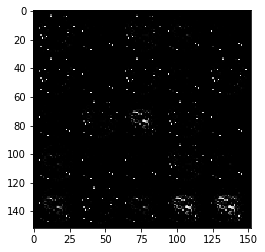

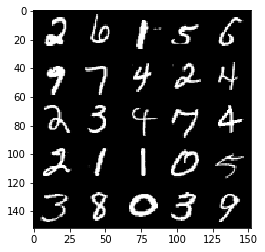

 57%|█████▋    | 267/469 [00:05<00:03, 58.33it/s]

Epoch 57, step 27000: Generator loss: 10.70078754425049, discriminator loss: 0.002153636746155825


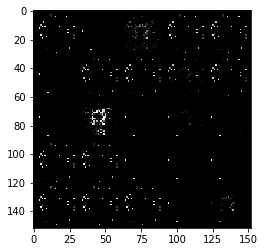

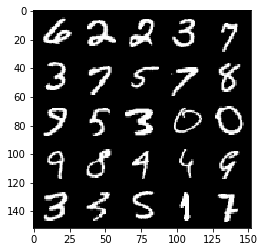

 64%|██████▎   | 298/469 [00:06<00:04, 41.38it/s]

Epoch 58, step 27500: Generator loss: 10.055185523986806, discriminator loss: 0.0008318948097094091


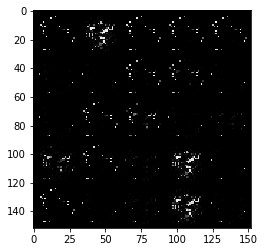

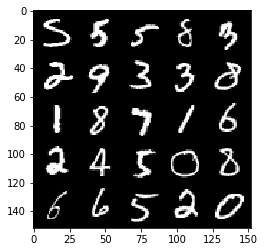

 70%|██████▉   | 326/469 [00:07<00:03, 41.08it/s]

Epoch 59, step 28000: Generator loss: 11.657799238204962, discriminator loss: 0.0010854285102250285


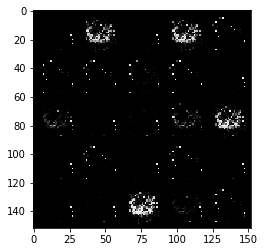

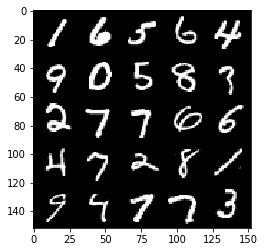

 76%|███████▌  | 357/469 [00:08<00:02, 42.03it/s]

Epoch 60, step 28500: Generator loss: 11.419950839996325, discriminator loss: 0.0017098837950234125


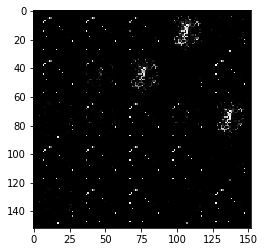

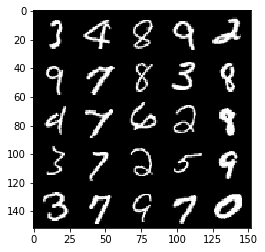

 83%|████████▎ | 387/469 [00:08<00:01, 43.16it/s]

Epoch 61, step 29000: Generator loss: 10.910291875839235, discriminator loss: 0.0007418627492588709


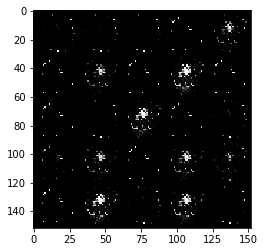

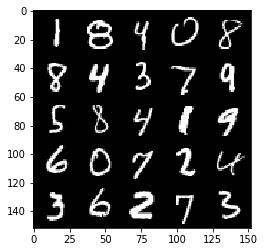

 90%|████████▉ | 422/469 [00:09<00:01, 42.39it/s]

Epoch 62, step 29500: Generator loss: 11.316754302978516, discriminator loss: 0.0018681683315453482


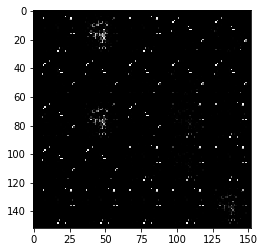

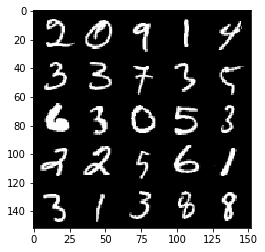

 96%|█████████▌| 449/469 [00:10<00:00, 41.33it/s]

Epoch 63, step 30000: Generator loss: 10.63441731262206, discriminator loss: 0.0014260050051325371


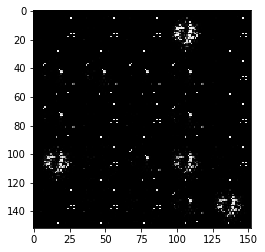

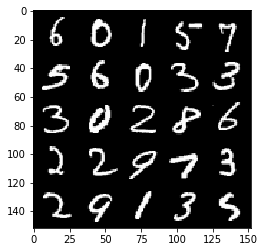

  3%|▎         | 15/469 [00:00<00:10, 44.25it/s]

Epoch 65, step 30500: Generator loss: 11.35924648666381, discriminator loss: 0.0031078358845898026


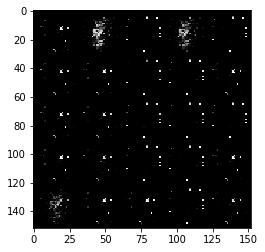

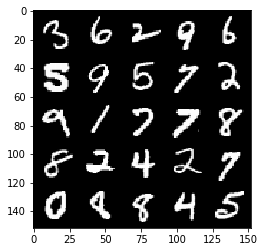

 10%|▉         | 46/469 [00:01<00:09, 44.49it/s]

Epoch 66, step 31000: Generator loss: 10.932907413482667, discriminator loss: 0.004831652947112168


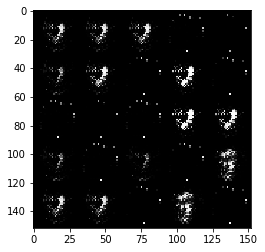

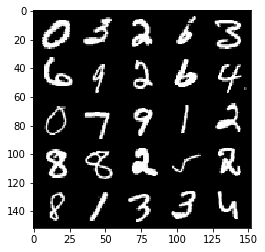

 16%|█▌        | 76/469 [00:01<00:09, 43.63it/s]

Epoch 67, step 31500: Generator loss: 11.35198987960816, discriminator loss: 0.005682304205991386


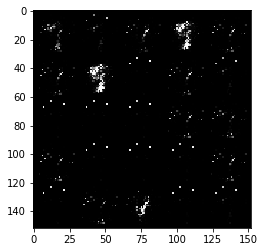

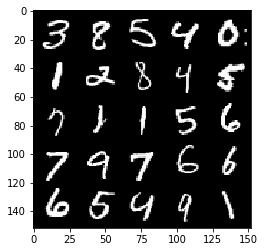

 22%|██▏       | 105/469 [00:01<00:06, 60.43it/s]

Epoch 68, step 32000: Generator loss: 11.073285900115959, discriminator loss: 0.005139179602389052


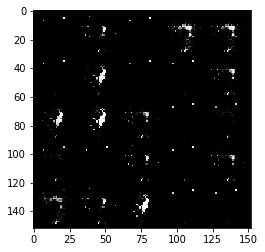

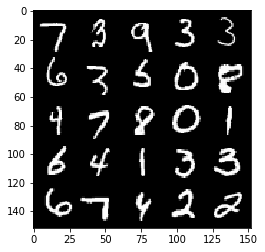

 28%|██▊       | 133/469 [00:02<00:05, 60.43it/s]

Epoch 69, step 32500: Generator loss: 12.039569316864004, discriminator loss: 0.005452262925777182


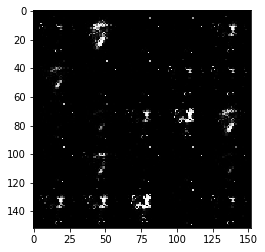

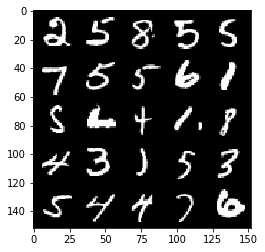

 35%|███▌      | 165/469 [00:02<00:05, 60.66it/s]

Epoch 70, step 33000: Generator loss: 10.881976655960083, discriminator loss: 0.006377539093336964


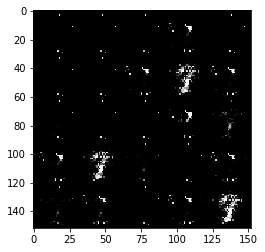

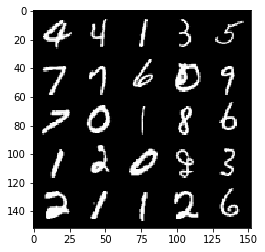

 43%|████▎     | 201/469 [00:03<00:04, 60.53it/s]

Epoch 71, step 33500: Generator loss: 11.231388462066652, discriminator loss: 0.00556434509749306


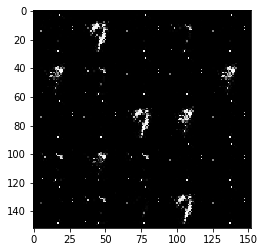

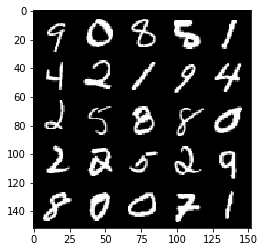

 49%|████▉     | 230/469 [00:03<00:03, 60.78it/s]

Epoch 72, step 34000: Generator loss: 11.082311748504633, discriminator loss: 0.004004134197515669


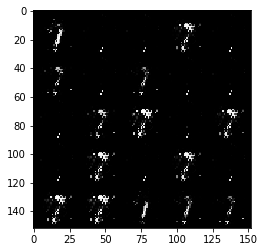

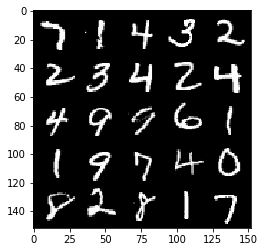

 55%|█████▌    | 258/469 [00:04<00:03, 60.62it/s]

Epoch 73, step 34500: Generator loss: 11.105991235733025, discriminator loss: 0.0071210557243321084


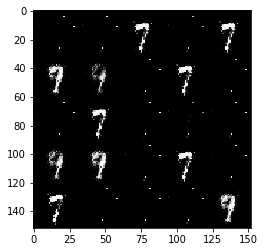

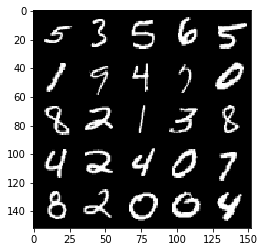

 62%|██████▏   | 290/469 [00:05<00:03, 48.12it/s]

Epoch 74, step 35000: Generator loss: 9.559631390571592, discriminator loss: 0.007802517421543595


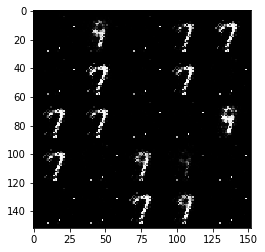

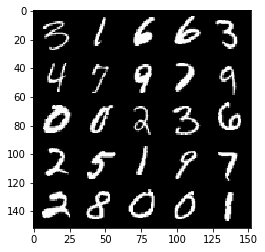

 68%|██████▊   | 321/469 [00:05<00:02, 60.25it/s]

Epoch 75, step 35500: Generator loss: 9.629149575233464, discriminator loss: 0.007674873622971059


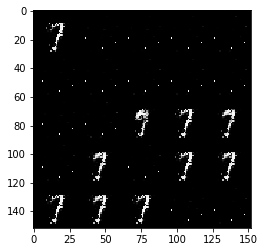

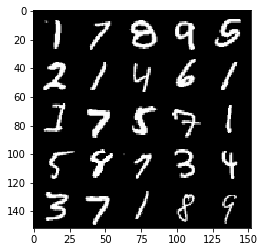

 76%|███████▌  | 356/469 [00:05<00:01, 60.89it/s]

Epoch 76, step 36000: Generator loss: 10.135473794937127, discriminator loss: 0.009207652328070255


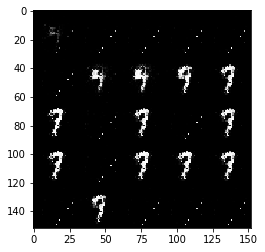

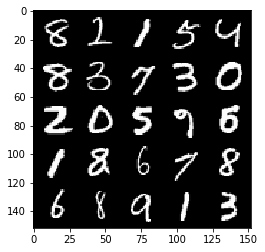

 82%|████████▏ | 386/469 [00:06<00:01, 60.59it/s]

Epoch 77, step 36500: Generator loss: 9.71586204147338, discriminator loss: 0.01193078435680582


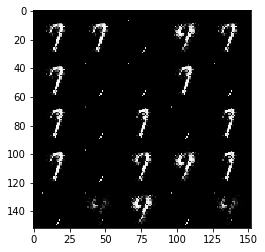

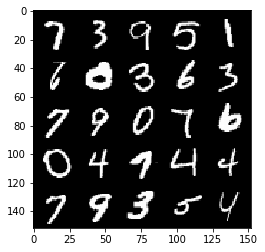

 89%|████████▊ | 416/469 [00:09<00:01, 42.49it/s]

Epoch 78, step 37000: Generator loss: 9.343089107513432, discriminator loss: 0.00992871785658645


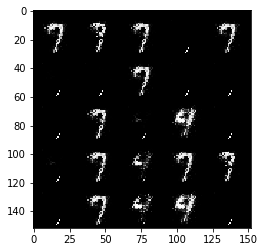

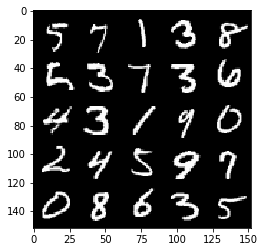

 96%|█████████▌| 448/469 [00:09<00:00, 42.17it/s]

Epoch 79, step 37500: Generator loss: 9.563429878234869, discriminator loss: 0.012654758470263905


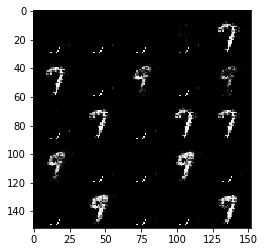

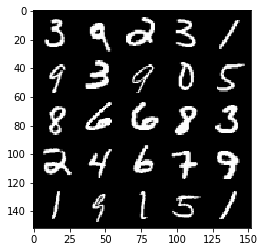

  2%|▏         | 9/469 [00:00<00:10, 43.69it/s]

Epoch 81, step 38000: Generator loss: 9.453485655784602, discriminator loss: 0.009860598222658145


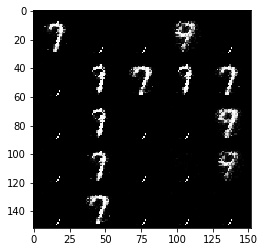

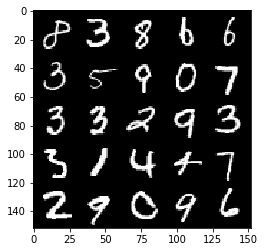

  9%|▊         | 41/469 [00:00<00:09, 45.07it/s]

Epoch 82, step 38500: Generator loss: 9.34924277973175, discriminator loss: 0.007074451784370481


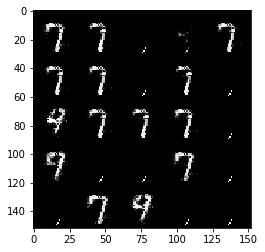

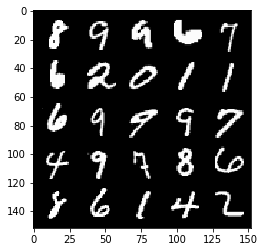

 15%|█▌        | 72/469 [00:01<00:08, 44.95it/s]

Epoch 83, step 39000: Generator loss: 9.438111239433288, discriminator loss: 0.008966445817262872


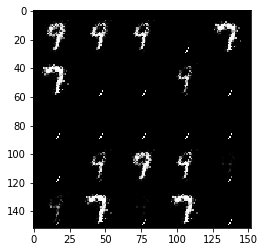

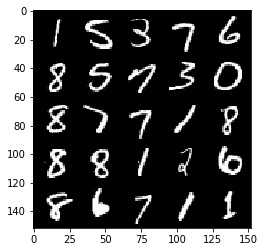

 22%|██▏       | 101/469 [00:02<00:07, 46.81it/s]

Epoch 84, step 39500: Generator loss: 9.419985833168036, discriminator loss: 0.010772110102436276


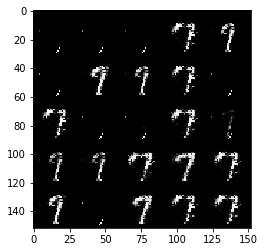

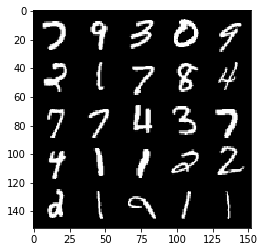

 28%|██▊       | 133/469 [00:02<00:08, 41.97it/s]

Epoch 85, step 40000: Generator loss: 10.438488738060006, discriminator loss: 0.013716980645822326


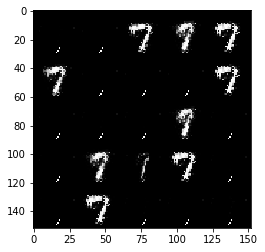

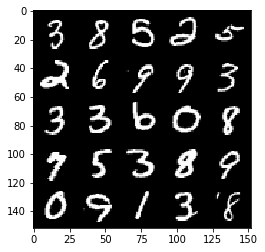

 35%|███▌      | 166/469 [00:03<00:07, 41.71it/s]

Epoch 86, step 40500: Generator loss: 10.140467847824091, discriminator loss: 0.012901777453211258


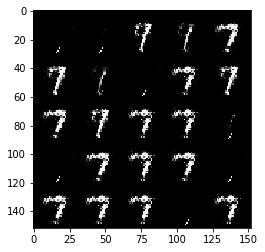

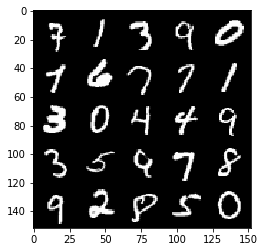

 42%|████▏     | 195/469 [00:03<00:04, 60.95it/s]

Epoch 87, step 41000: Generator loss: 9.988870300292973, discriminator loss: 0.009768091638426988


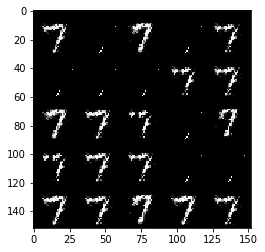

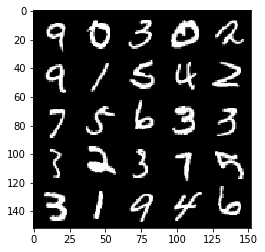

 48%|████▊     | 223/469 [00:03<00:04, 61.00it/s]

Epoch 88, step 41500: Generator loss: 10.316461671829218, discriminator loss: 0.011115441417336109


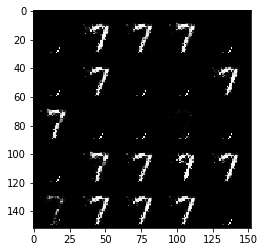

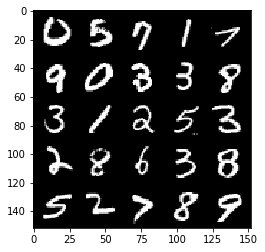

 55%|█████▍    | 256/469 [00:06<00:05, 41.72it/s]

Epoch 89, step 42000: Generator loss: 9.628755741119383, discriminator loss: 0.01749623837135733


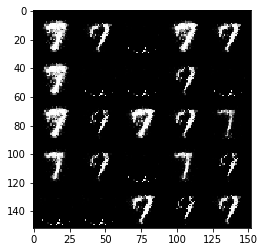

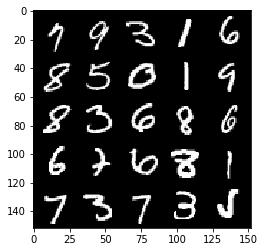

 61%|██████▏   | 288/469 [00:06<00:04, 42.72it/s]

Epoch 90, step 42500: Generator loss: 8.999237099647525, discriminator loss: 0.011687752626894515


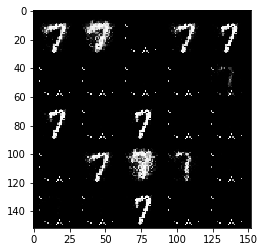

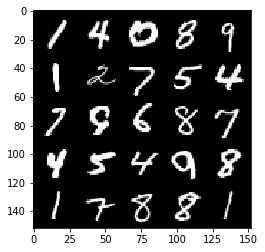

 68%|██████▊   | 317/469 [00:07<00:03, 43.21it/s]

Epoch 91, step 43000: Generator loss: 9.869455087661745, discriminator loss: 0.015089040091130301


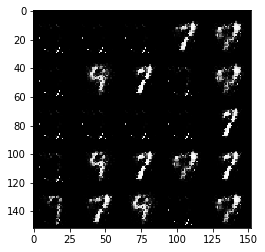

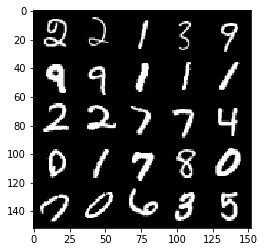

 75%|███████▌  | 352/469 [00:08<00:02, 42.41it/s]

Epoch 92, step 43500: Generator loss: 9.680900789260864, discriminator loss: 0.027969140561704974


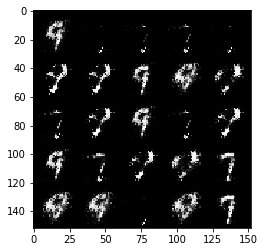

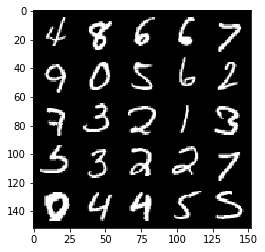

 81%|████████  | 380/469 [00:08<00:01, 45.80it/s]

Epoch 93, step 44000: Generator loss: 9.432498435974116, discriminator loss: 0.02282514603738673


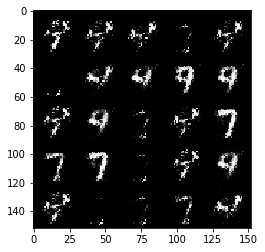

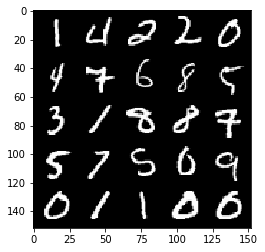

 88%|████████▊ | 413/469 [00:06<00:00, 60.79it/s]

Epoch 94, step 44500: Generator loss: 8.571978978157036, discriminator loss: 0.01764194103376937


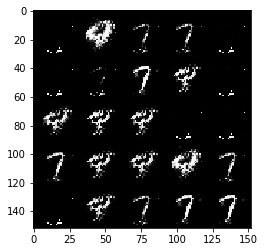

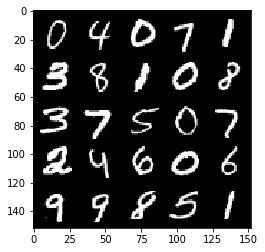

 95%|█████████▍| 445/469 [00:09<00:00, 43.05it/s]

Epoch 95, step 45000: Generator loss: 8.544684224128723, discriminator loss: 0.015563190843909976


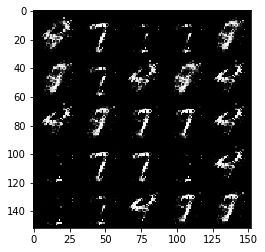

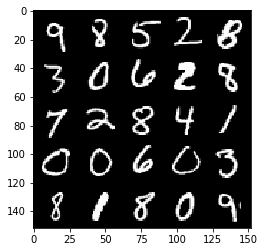

  1%|          | 5/469 [00:00<00:10, 45.41it/s]

Epoch 97, step 45500: Generator loss: 9.715319379806525, discriminator loss: 0.01766742378345225


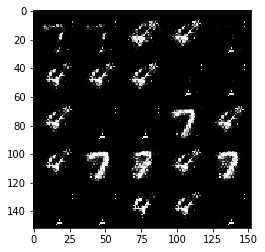

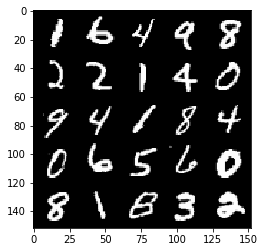

  8%|▊         | 36/469 [00:00<00:09, 43.31it/s]

Epoch 98, step 46000: Generator loss: 8.609723474502562, discriminator loss: 0.037612508398247854


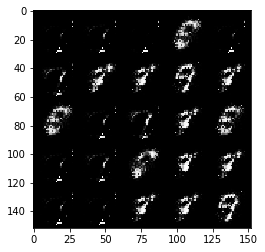

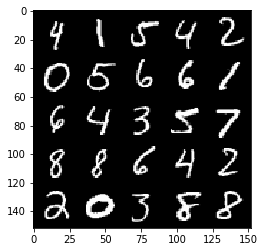

 14%|█▍        | 65/469 [00:01<00:08, 48.13it/s]

Epoch 99, step 46500: Generator loss: 8.218515422821055, discriminator loss: 0.025906296735862252


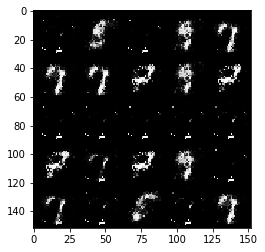

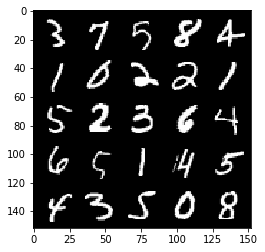

 21%|██        | 97/469 [00:01<00:06, 53.41it/s]

Epoch 100, step 47000: Generator loss: 8.605082423210145, discriminator loss: 0.03500389470113441


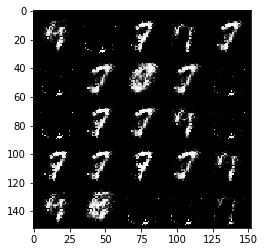

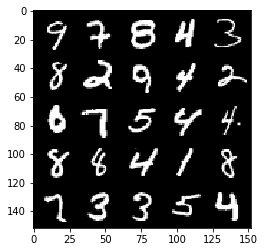

 27%|██▋       | 126/469 [00:02<00:05, 60.57it/s]

Epoch 101, step 47500: Generator loss: 8.141510714530941, discriminator loss: 0.03726029907399789


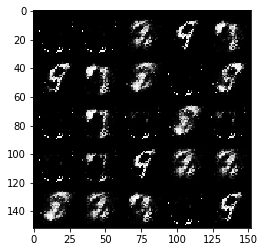

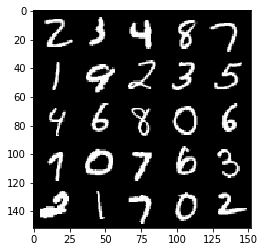

 34%|███▍      | 160/469 [00:02<00:05, 60.59it/s]

Epoch 102, step 48000: Generator loss: 8.324939396858221, discriminator loss: 0.02823345312278254


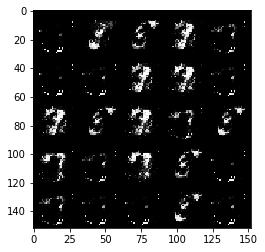

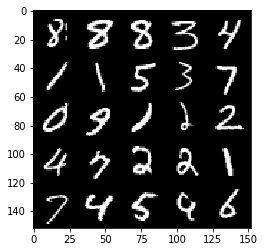

 40%|████      | 188/469 [00:03<00:04, 59.03it/s]

Epoch 103, step 48500: Generator loss: 8.113825287818909, discriminator loss: 0.018200620411895217


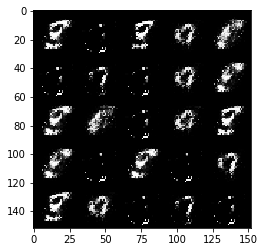

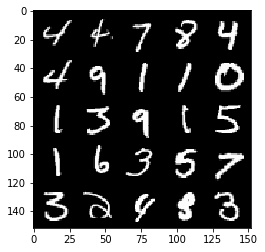

 47%|████▋     | 221/469 [00:04<00:05, 41.90it/s]

Epoch 104, step 49000: Generator loss: 7.691639916419984, discriminator loss: 0.024299421677831584


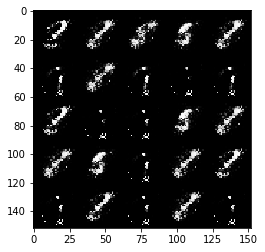

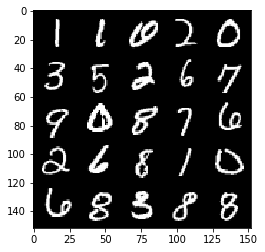

 54%|█████▍    | 255/469 [00:05<00:04, 43.28it/s]

Epoch 105, step 49500: Generator loss: 8.405113373756414, discriminator loss: 0.020965575018431975


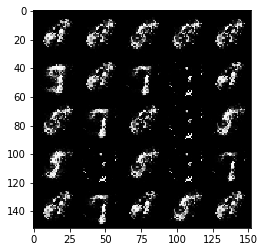

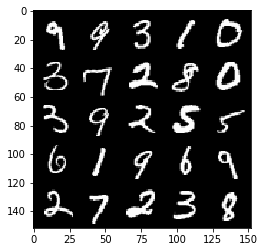

 61%|██████    | 286/469 [00:04<00:03, 60.59it/s]

Epoch 106, step 50000: Generator loss: 7.428714139938364, discriminator loss: 0.023180865547154105


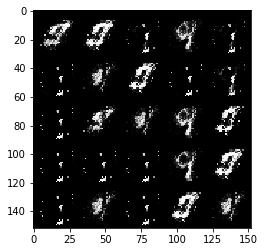

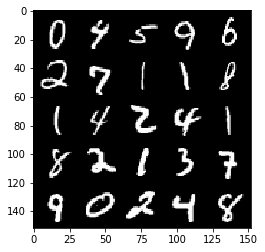

 67%|██████▋   | 313/469 [00:05<00:02, 60.54it/s]

Epoch 107, step 50500: Generator loss: 7.964782872200015, discriminator loss: 0.02352175508229995


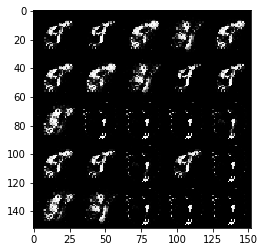

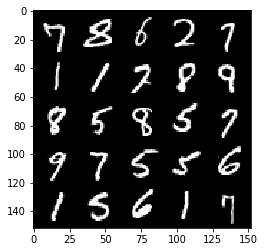

 74%|███████▍  | 347/469 [00:05<00:02, 56.86it/s]

Epoch 108, step 51000: Generator loss: 7.503571011543278, discriminator loss: 0.022969484179979183


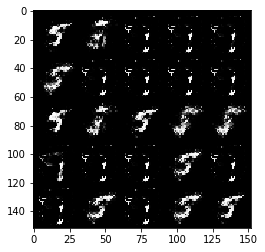

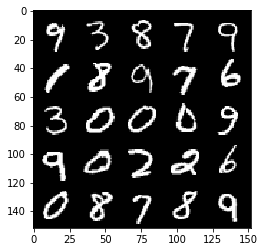

 81%|████████  | 379/469 [00:08<00:02, 41.79it/s]

Epoch 109, step 51500: Generator loss: 6.728664439201356, discriminator loss: 0.015942674025194722


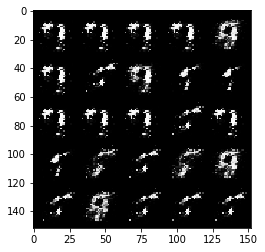

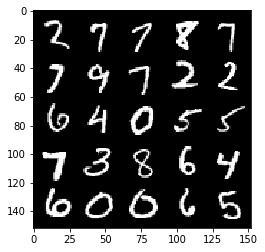

 87%|████████▋ | 408/469 [00:06<00:01, 60.46it/s]

Epoch 110, step 52000: Generator loss: 8.473659677505498, discriminator loss: 0.013345923414046414


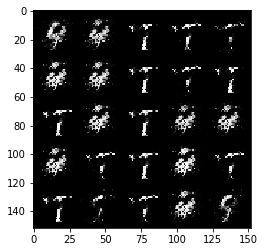

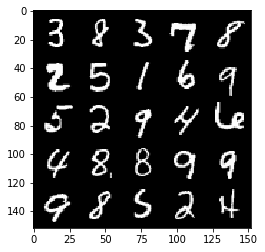

 94%|█████████▎| 439/469 [00:07<00:00, 60.45it/s]

Epoch 111, step 52500: Generator loss: 8.396768579483036, discriminator loss: 0.018488078192982343


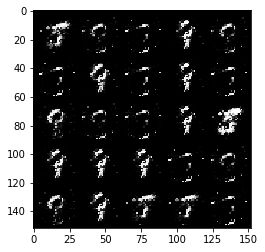

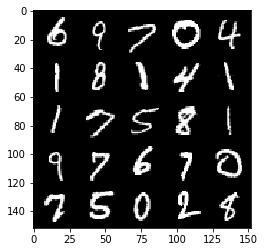

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 113, step 53000: Generator loss: 8.62326912403107, discriminator loss: 0.02117821555541011


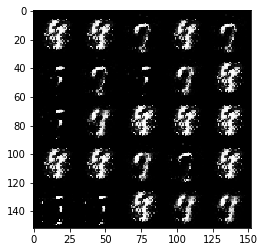

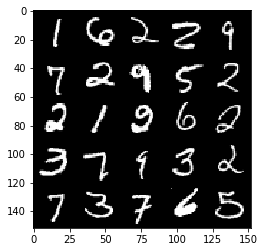

  7%|▋         | 32/469 [00:00<00:09, 47.29it/s]

Epoch 114, step 53500: Generator loss: 7.664356953620912, discriminator loss: 0.018983052357216378


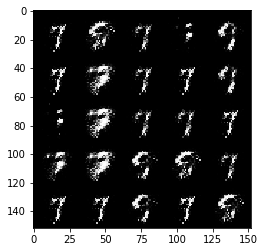

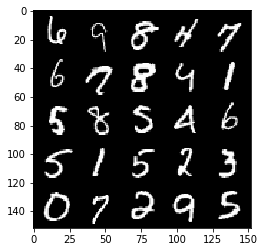

 14%|█▍        | 65/469 [00:01<00:09, 43.17it/s]

Epoch 115, step 54000: Generator loss: 6.760238832473755, discriminator loss: 0.018315059122513067


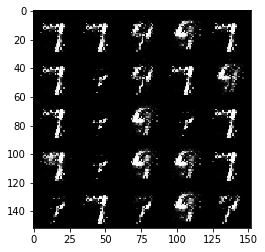

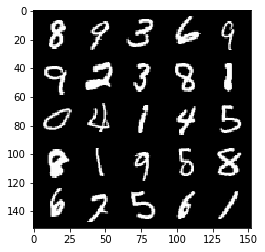

 20%|██        | 95/469 [00:01<00:06, 59.86it/s]

Epoch 116, step 54500: Generator loss: 6.735226398468023, discriminator loss: 0.02019672913406977


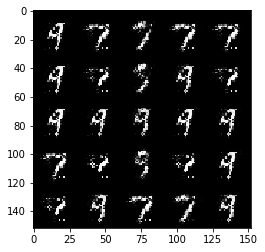

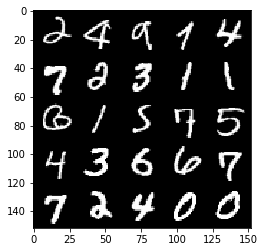

 26%|██▌       | 123/469 [00:02<00:05, 60.26it/s]

Epoch 117, step 55000: Generator loss: 6.436272670745853, discriminator loss: 0.030636969896964735


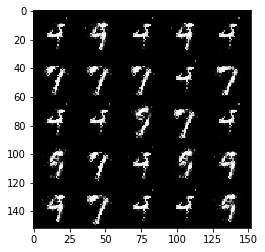

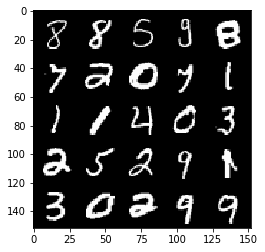

 32%|███▏      | 152/469 [00:02<00:05, 60.60it/s]

Epoch 118, step 55500: Generator loss: 5.841152232170101, discriminator loss: 0.03194143801857718


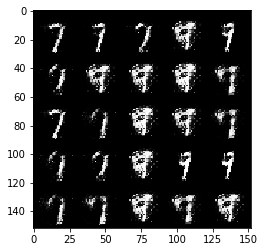

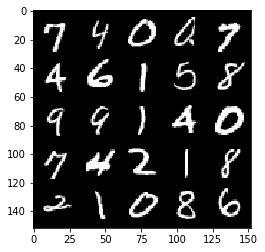

 40%|████      | 188/469 [00:03<00:06, 43.93it/s]

Epoch 119, step 56000: Generator loss: 5.626017556190489, discriminator loss: 0.03921861284715125


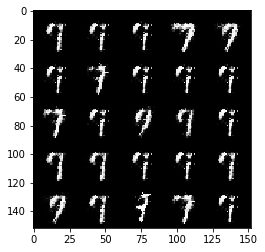

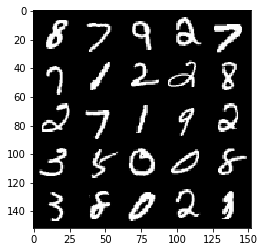

 46%|████▌     | 216/469 [00:03<00:04, 60.56it/s]

Epoch 120, step 56500: Generator loss: 5.656909539699555, discriminator loss: 0.03411451448756272


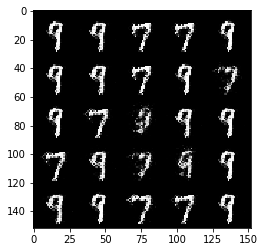

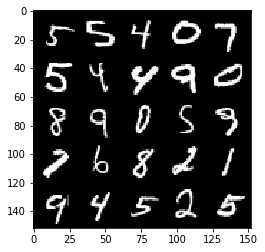

 54%|█████▎    | 251/469 [00:04<00:03, 60.67it/s]

Epoch 121, step 57000: Generator loss: 5.532879372119904, discriminator loss: 0.04539696832979097


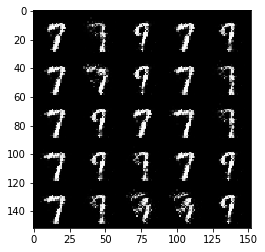

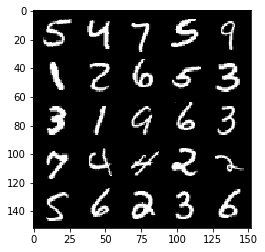

 59%|█████▉    | 278/469 [00:06<00:04, 43.04it/s]

Epoch 122, step 57500: Generator loss: 5.537307911396029, discriminator loss: 0.04703749490715564


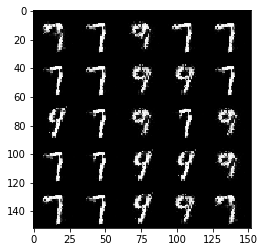

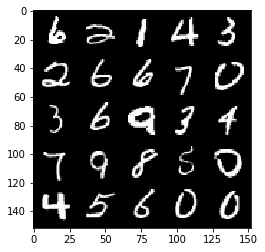

 67%|██████▋   | 312/469 [00:07<00:03, 41.34it/s]

Epoch 123, step 58000: Generator loss: 5.299001859664918, discriminator loss: 0.05032095279172065


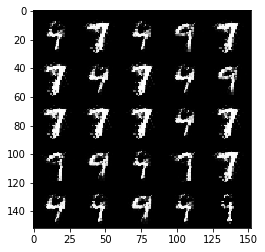

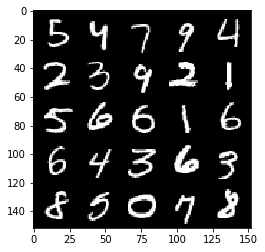

 73%|███████▎  | 342/469 [00:07<00:03, 41.45it/s]

Epoch 124, step 58500: Generator loss: 5.460166200160988, discriminator loss: 0.03832191659230741


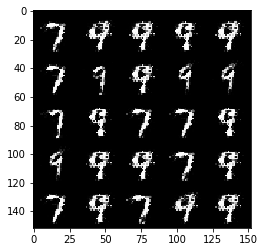

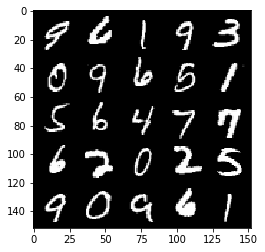

 79%|███████▉  | 371/469 [00:08<00:02, 41.87it/s]

Epoch 125, step 59000: Generator loss: 5.307690107822417, discriminator loss: 0.046665552872698794


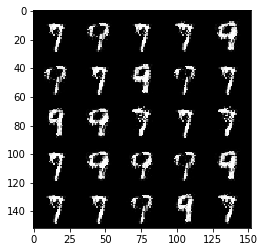

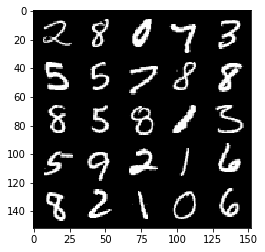

 86%|████████▌ | 402/469 [00:09<00:01, 42.82it/s]

Epoch 126, step 59500: Generator loss: 5.412076187133792, discriminator loss: 0.04600355757726356


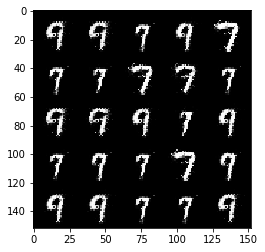

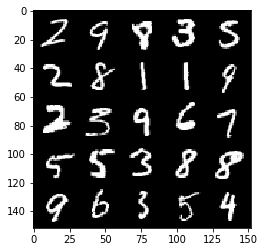

 93%|█████████▎| 437/469 [00:10<00:00, 43.60it/s]

Epoch 127, step 60000: Generator loss: 5.870520107269289, discriminator loss: 0.02631896610418332


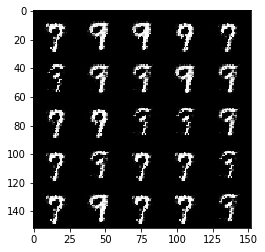

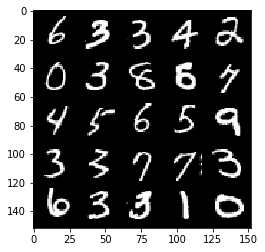

100%|█████████▉| 468/469 [00:07<00:00, 60.36it/s]

Epoch 128, step 60500: Generator loss: 6.069127883434297, discriminator loss: 0.025853099042549756


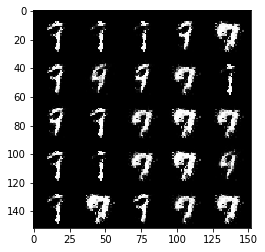

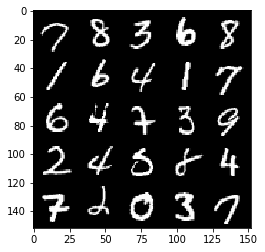

  6%|▋         | 30/469 [00:00<00:09, 44.35it/s]

Epoch 130, step 61000: Generator loss: 6.5795484409332285, discriminator loss: 0.0219325860326644


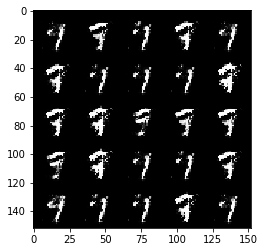

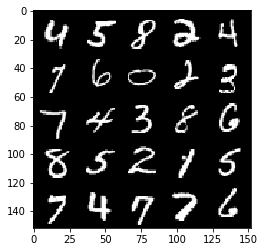

 12%|█▏        | 55/469 [00:00<00:06, 60.68it/s]

Epoch 131, step 61500: Generator loss: 5.900440612316136, discriminator loss: 0.04610863886610609


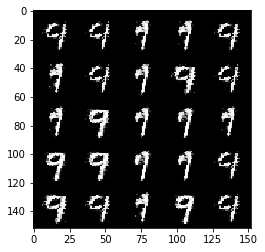

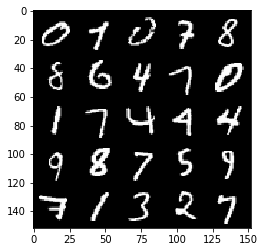

 19%|█▉        | 90/469 [00:02<00:08, 42.83it/s]

Epoch 132, step 62000: Generator loss: 5.815607850551609, discriminator loss: 0.03303127691615373


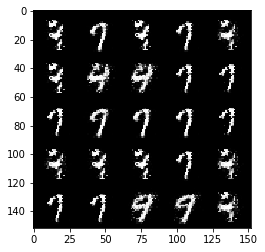

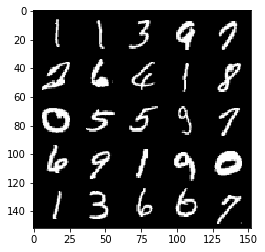

 26%|██▌       | 120/469 [00:02<00:08, 41.93it/s]

Epoch 133, step 62500: Generator loss: 5.620307663440707, discriminator loss: 0.03109275698242708


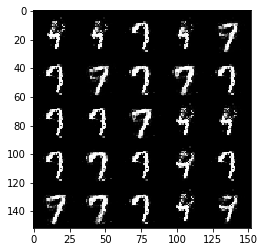

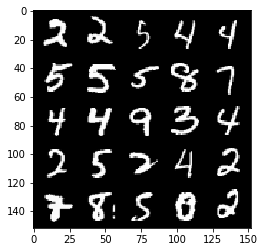

 32%|███▏      | 151/469 [00:03<00:07, 43.28it/s]

Epoch 134, step 63000: Generator loss: 5.875575509071353, discriminator loss: 0.03985101624671369


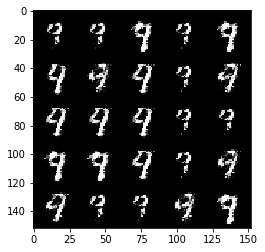

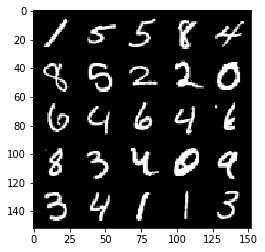

 38%|███▊      | 179/469 [00:02<00:04, 60.51it/s]

Epoch 135, step 63500: Generator loss: 5.575887356758109, discriminator loss: 0.034317826703656476


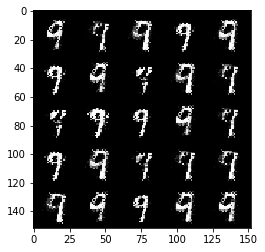

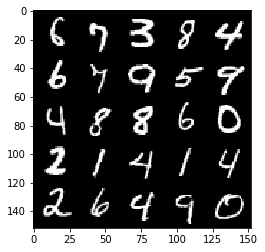

 46%|████▌     | 216/469 [00:03<00:04, 60.67it/s]

Epoch 136, step 64000: Generator loss: 5.842784818649293, discriminator loss: 0.036165253053419284


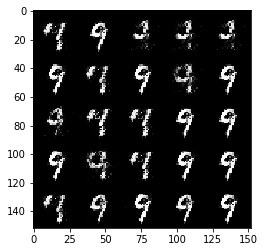

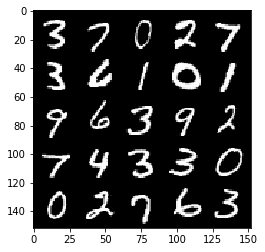

 52%|█████▏    | 244/469 [00:04<00:05, 44.29it/s]

Epoch 137, step 64500: Generator loss: 5.5976088232994075, discriminator loss: 0.04681992265582084


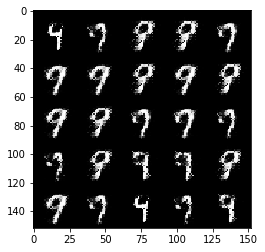

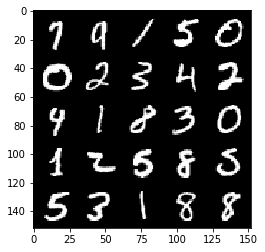

 58%|█████▊    | 274/469 [00:06<00:04, 41.73it/s]

Epoch 138, step 65000: Generator loss: 5.414516555309294, discriminator loss: 0.040506823944393554


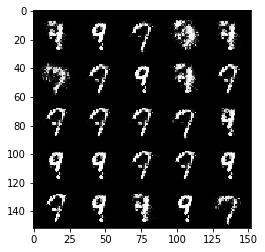

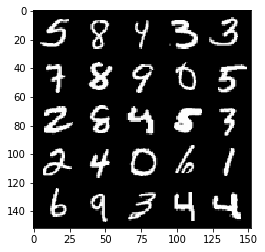

 65%|██████▌   | 306/469 [00:05<00:02, 60.16it/s]

Epoch 139, step 65500: Generator loss: 5.603312257289883, discriminator loss: 0.038698305659927455


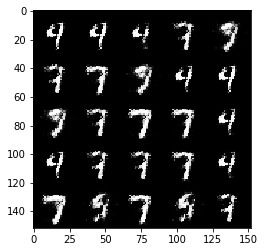

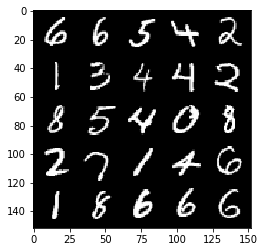

 71%|███████▏  | 335/469 [00:05<00:02, 60.64it/s]

Epoch 140, step 66000: Generator loss: 5.297112743854526, discriminator loss: 0.04947799842897806


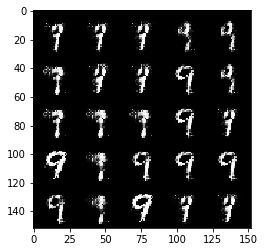

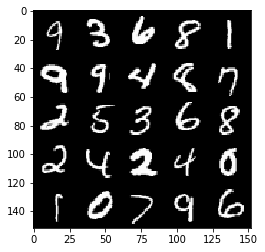

 79%|███████▉  | 370/469 [00:06<00:01, 60.87it/s]

Epoch 141, step 66500: Generator loss: 5.420960284709929, discriminator loss: 0.038869666797109


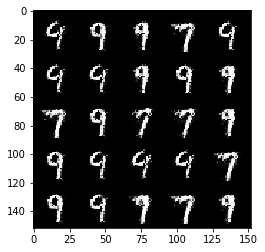

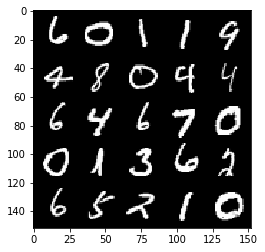

 86%|████████▌ | 401/469 [00:09<00:01, 41.57it/s]

Epoch 142, step 67000: Generator loss: 5.121895010471337, discriminator loss: 0.04517988864379002


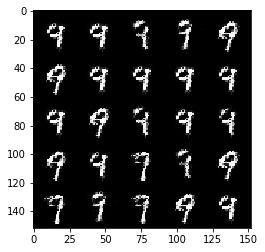

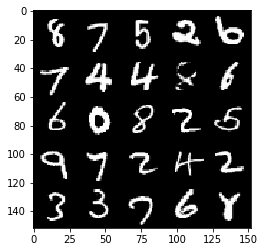

 92%|█████████▏| 432/469 [00:09<00:00, 43.40it/s]

Epoch 143, step 67500: Generator loss: 5.476641797065738, discriminator loss: 0.04725190457422284


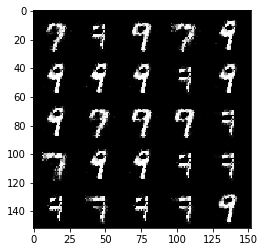

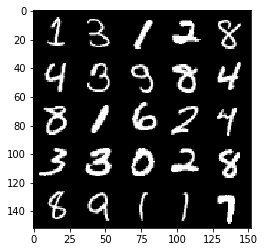

 98%|█████████▊| 459/469 [00:08<00:00, 60.73it/s]

Epoch 144, step 68000: Generator loss: 5.340999576568604, discriminator loss: 0.043236891969107086


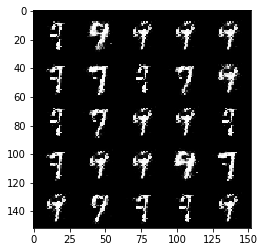

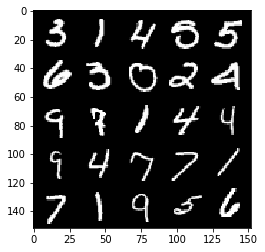

  4%|▍         | 20/469 [00:00<00:07, 60.25it/s]

Epoch 146, step 68500: Generator loss: 5.24745609283447, discriminator loss: 0.046495647839270494


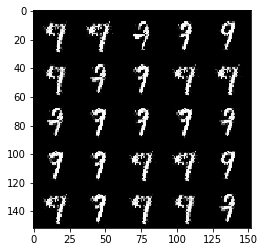

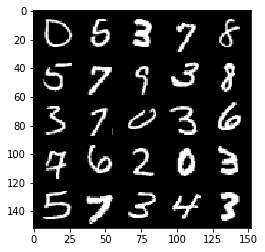

 12%|█▏        | 56/469 [00:00<00:06, 60.79it/s]

Epoch 147, step 69000: Generator loss: 5.043043350219726, discriminator loss: 0.04637520412215962


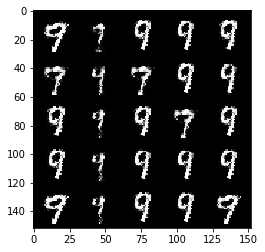

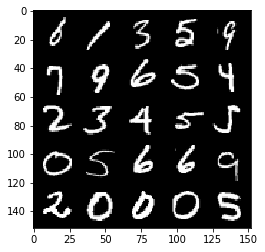

 18%|█▊        | 83/469 [00:01<00:06, 60.84it/s]

Epoch 148, step 69500: Generator loss: 5.293362540721895, discriminator loss: 0.03995430187229066


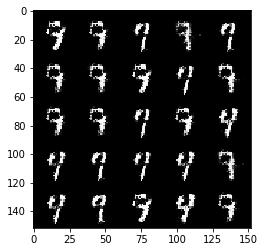

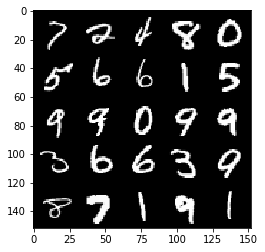

 25%|██▍       | 117/469 [00:01<00:05, 60.86it/s]

Epoch 149, step 70000: Generator loss: 5.301898464679712, discriminator loss: 0.047204509446863066


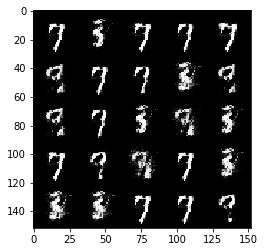

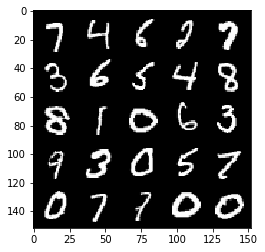

 31%|███       | 146/469 [00:02<00:05, 60.73it/s]

Epoch 150, step 70500: Generator loss: 5.006369387626652, discriminator loss: 0.06668535987660289


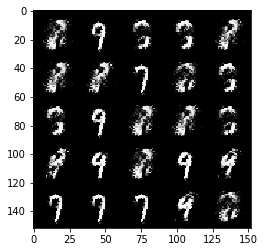

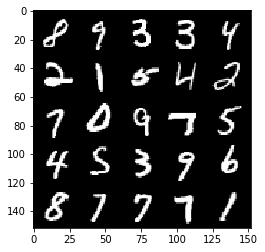

 38%|███▊      | 180/469 [00:02<00:04, 60.63it/s]

Epoch 151, step 71000: Generator loss: 4.762886986255642, discriminator loss: 0.06713138311728838


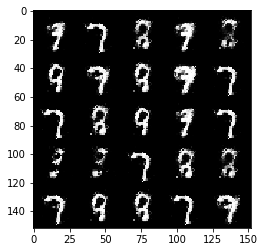

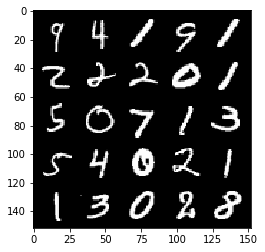

 45%|████▍     | 209/469 [00:03<00:04, 60.66it/s]

Epoch 152, step 71500: Generator loss: 4.611083586215974, discriminator loss: 0.05197494507580999


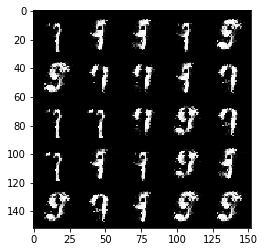

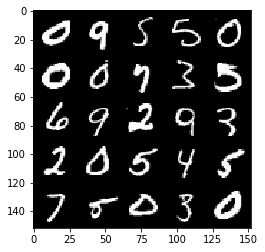

 51%|█████     | 237/469 [00:05<00:03, 59.48it/s]

Epoch 153, step 72000: Generator loss: 5.716295507431035, discriminator loss: 0.04414446557639171


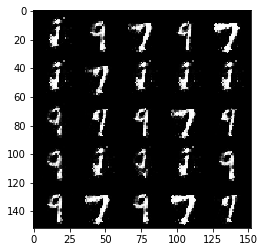

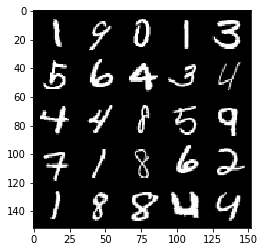

 58%|█████▊    | 272/469 [00:04<00:03, 60.75it/s]

Epoch 154, step 72500: Generator loss: 4.737244742870333, discriminator loss: 0.059907173055224056


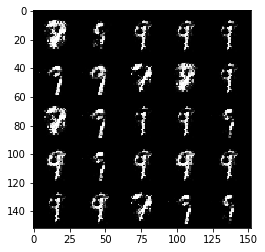

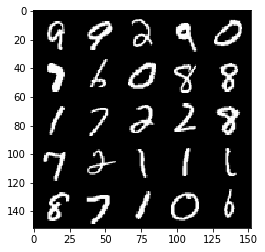

 64%|██████▍   | 300/469 [00:04<00:02, 60.66it/s]

Epoch 155, step 73000: Generator loss: 4.683448873043059, discriminator loss: 0.05293033289443706


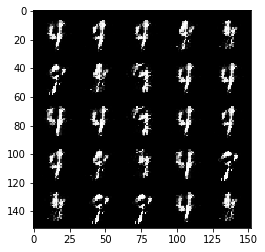

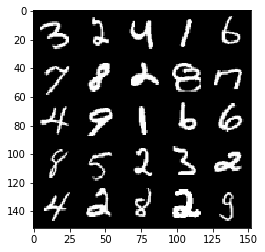

 71%|███████   | 332/469 [00:07<00:03, 43.21it/s]

Epoch 156, step 73500: Generator loss: 5.052114801883695, discriminator loss: 0.047435870626941275


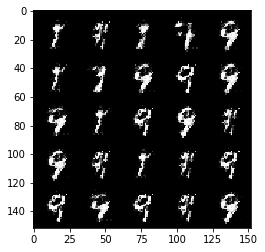

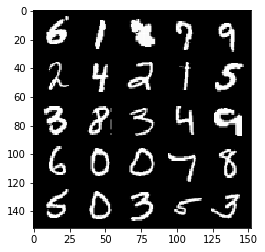

 78%|███████▊  | 364/469 [00:08<00:02, 41.91it/s]

Epoch 157, step 74000: Generator loss: 5.034130145549775, discriminator loss: 0.055573820839636


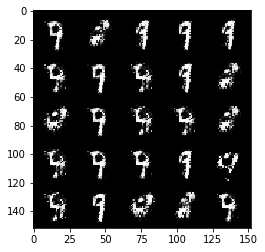

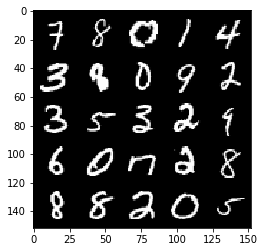

 84%|████████▍ | 396/469 [00:09<00:01, 41.62it/s]

Epoch 158, step 74500: Generator loss: 4.677138003349308, discriminator loss: 0.05137173076719046


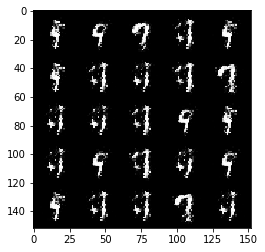

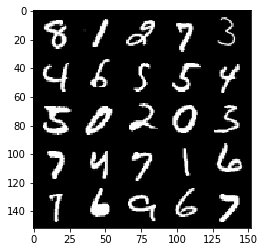

 91%|█████████ | 426/469 [00:09<00:01, 41.64it/s]

Epoch 159, step 75000: Generator loss: 5.333649432182312, discriminator loss: 0.0515430627446622


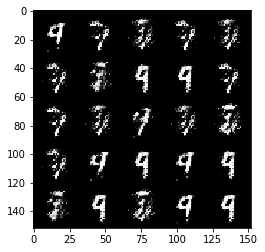

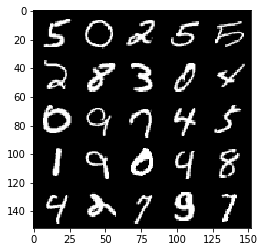

 98%|█████████▊| 458/469 [00:09<00:00, 41.53it/s]

Epoch 160, step 75500: Generator loss: 4.652618125915529, discriminator loss: 0.05351165525615213


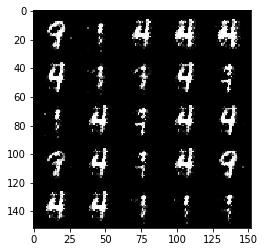

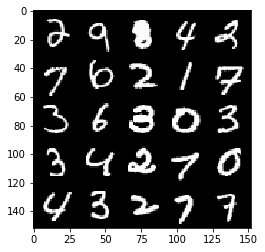

  4%|▍         | 21/469 [00:00<00:09, 49.04it/s]

Epoch 162, step 76000: Generator loss: 4.974802790164946, discriminator loss: 0.04896323534380644


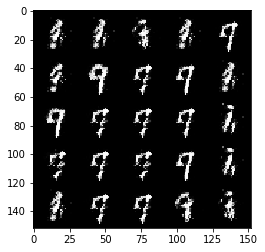

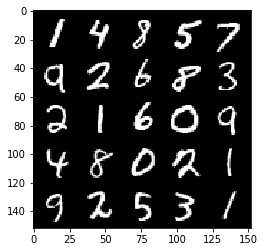

 11%|█▏        | 53/469 [00:00<00:07, 54.61it/s]

Epoch 163, step 76500: Generator loss: 4.865479195117955, discriminator loss: 0.04715247573703528


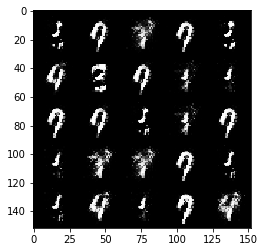

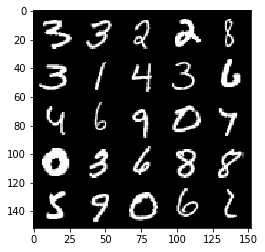

 17%|█▋        | 82/469 [00:01<00:08, 46.13it/s]

Epoch 164, step 77000: Generator loss: 5.207737139225014, discriminator loss: 0.04496378722228108


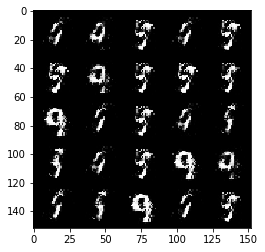

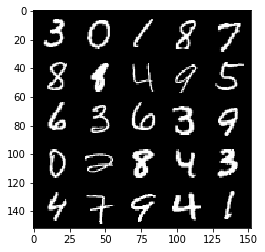

 23%|██▎       | 110/469 [00:01<00:05, 60.83it/s]

Epoch 165, step 77500: Generator loss: 5.203329252719877, discriminator loss: 0.044578170694410814


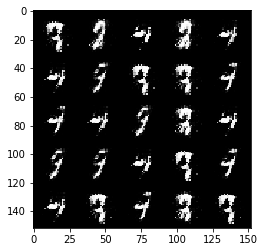

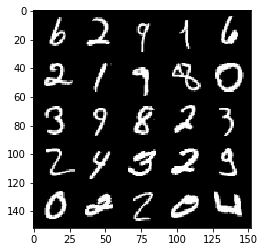

 31%|███       | 144/469 [00:02<00:05, 60.54it/s]

Epoch 166, step 78000: Generator loss: 5.29209566116333, discriminator loss: 0.03738119488488884


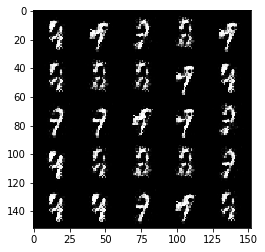

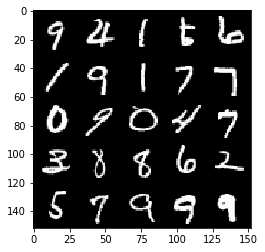

 37%|███▋      | 175/469 [00:02<00:04, 61.18it/s]

Epoch 167, step 78500: Generator loss: 5.373853168964388, discriminator loss: 0.05121879349695516


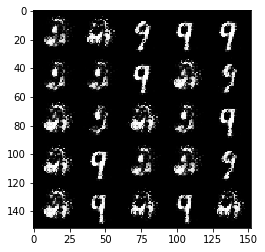

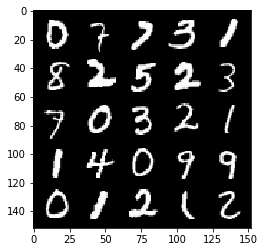

 44%|████▍     | 208/469 [00:03<00:04, 61.03it/s]

Epoch 168, step 79000: Generator loss: 4.59735468578339, discriminator loss: 0.06354437407292425


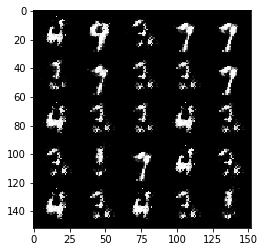

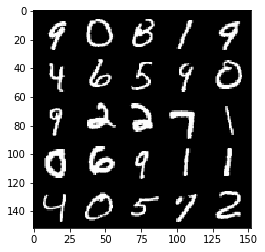

 50%|█████     | 236/469 [00:03<00:03, 60.51it/s]

Epoch 169, step 79500: Generator loss: 4.99042867660522, discriminator loss: 0.04723839268181475


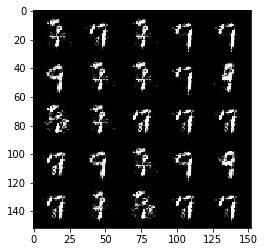

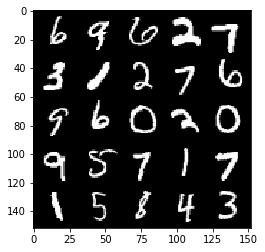

 57%|█████▋    | 269/469 [00:04<00:03, 60.65it/s]

Epoch 170, step 80000: Generator loss: 4.84257249212265, discriminator loss: 0.05170551340933884


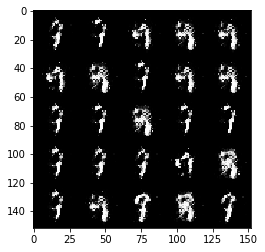

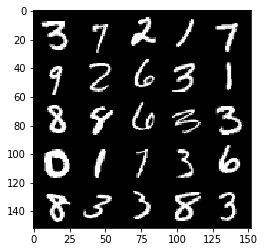

 64%|██████▍   | 301/469 [00:04<00:02, 60.70it/s]

Epoch 171, step 80500: Generator loss: 4.850600833892819, discriminator loss: 0.05021115079335866


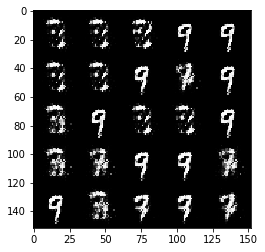

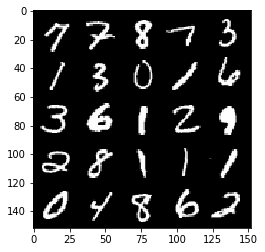

 70%|██████▉   | 327/469 [00:05<00:02, 60.05it/s]

Epoch 172, step 81000: Generator loss: 5.269953041553502, discriminator loss: 0.043870692440308605


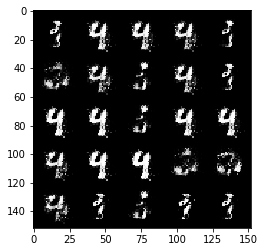

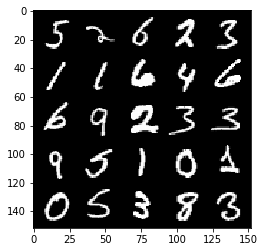

 77%|███████▋  | 362/469 [00:05<00:01, 60.56it/s]

Epoch 173, step 81500: Generator loss: 5.267060379028312, discriminator loss: 0.0448258232790977


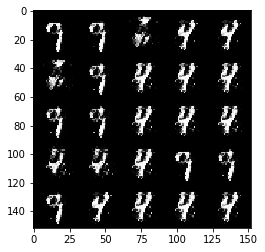

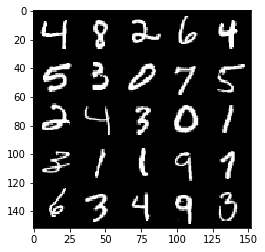

 84%|████████▎ | 392/469 [00:06<00:01, 60.56it/s]

Epoch 174, step 82000: Generator loss: 5.009807986736295, discriminator loss: 0.0495939536439255


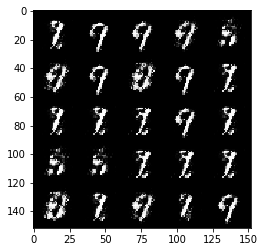

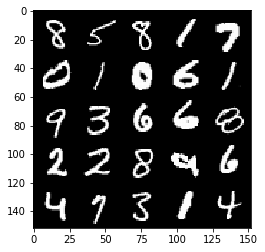

 89%|████████▉ | 419/469 [00:06<00:00, 60.11it/s]

Epoch 175, step 82500: Generator loss: 5.1416096787452705, discriminator loss: 0.059177554243244196


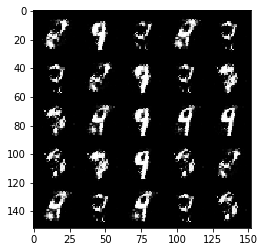

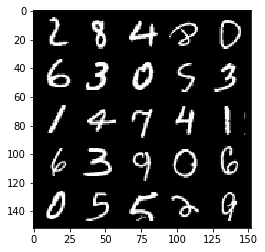

 97%|█████████▋| 456/469 [00:09<00:00, 43.99it/s]

Epoch 176, step 83000: Generator loss: 4.5506489453315755, discriminator loss: 0.0708998050224036


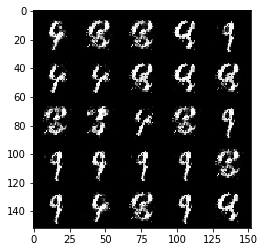

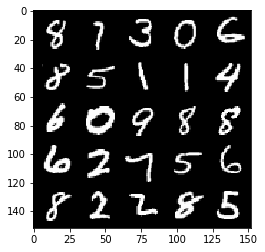

  3%|▎         | 13/469 [00:00<00:07, 59.23it/s]

Epoch 178, step 83500: Generator loss: 4.459457672119147, discriminator loss: 0.06199545435607432


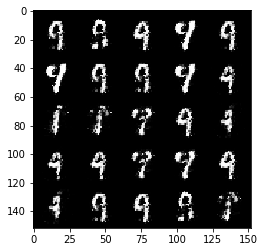

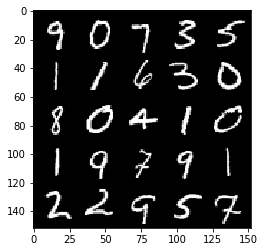

 10%|█         | 49/469 [00:01<00:09, 43.97it/s]

Epoch 179, step 84000: Generator loss: 4.343036863803858, discriminator loss: 0.07508867613598708


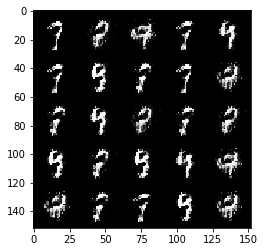

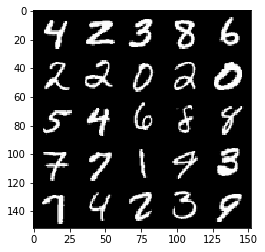

 16%|█▌        | 74/469 [00:01<00:06, 60.54it/s]

Epoch 180, step 84500: Generator loss: 4.441979419708251, discriminator loss: 0.06332754413783553


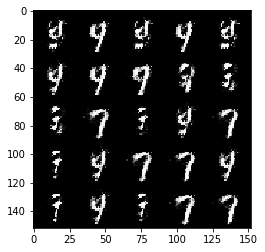

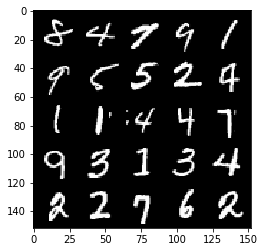

 23%|██▎       | 107/469 [00:02<00:08, 42.46it/s]

Epoch 181, step 85000: Generator loss: 4.474587887287135, discriminator loss: 0.06201948282495139


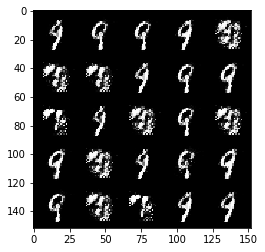

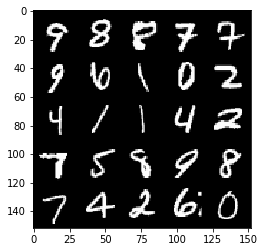

 30%|███       | 141/469 [00:03<00:07, 42.83it/s]

Epoch 182, step 85500: Generator loss: 4.7096297912597604, discriminator loss: 0.05625080687366425


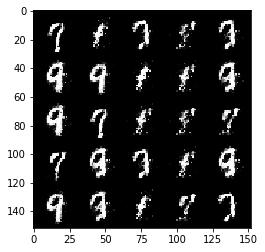

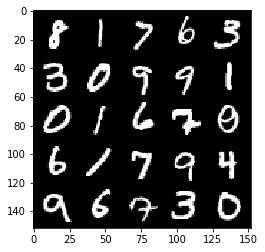

 37%|███▋      | 172/469 [00:03<00:06, 48.45it/s]

Epoch 183, step 86000: Generator loss: 4.432419796943664, discriminator loss: 0.06128522357903421


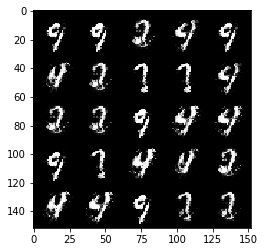

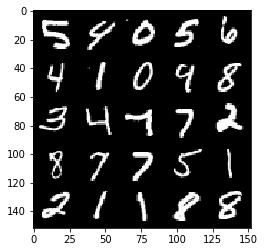

 43%|████▎     | 200/469 [00:04<00:06, 42.68it/s]

Epoch 184, step 86500: Generator loss: 4.430407297611231, discriminator loss: 0.058143412070348864


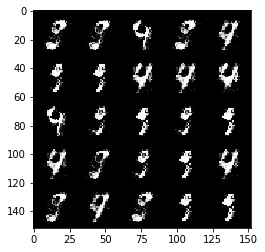

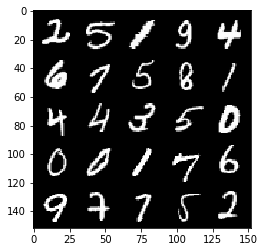

 49%|████▉     | 229/469 [00:03<00:03, 60.87it/s]

Epoch 185, step 87000: Generator loss: 4.460203963756565, discriminator loss: 0.06539376464113597


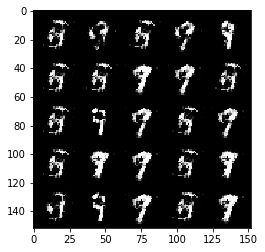

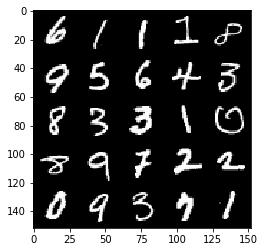

 57%|█████▋    | 265/469 [00:04<00:03, 60.69it/s]

Epoch 186, step 87500: Generator loss: 4.145326555252076, discriminator loss: 0.07661212561279541


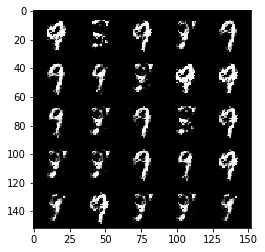

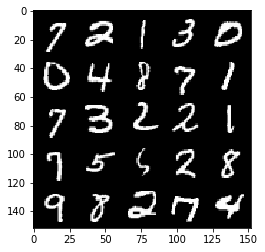

 62%|██████▏   | 291/469 [00:04<00:02, 60.91it/s]

Epoch 187, step 88000: Generator loss: 4.573665681838986, discriminator loss: 0.05028603736031801


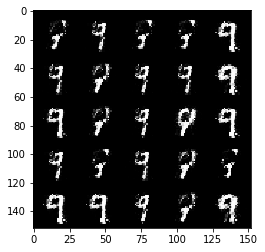

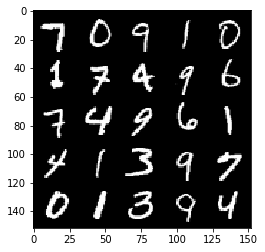

 69%|██████▊   | 322/469 [00:05<00:02, 61.08it/s]

Epoch 188, step 88500: Generator loss: 4.602658688545231, discriminator loss: 0.05558008918166158


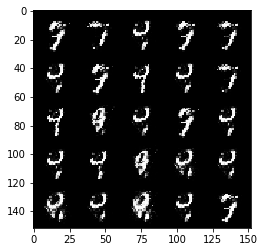

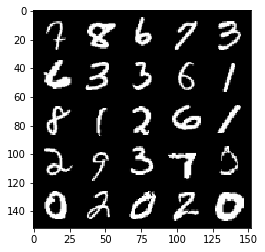

 76%|███████▋  | 358/469 [00:07<00:02, 42.40it/s]

Epoch 189, step 89000: Generator loss: 4.5253462166786225, discriminator loss: 0.060791988385841274


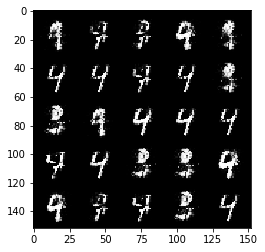

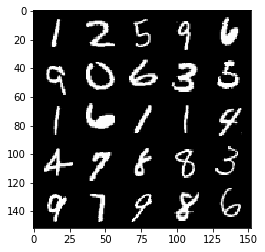

 83%|████████▎ | 388/469 [00:08<00:01, 42.15it/s]

Epoch 190, step 89500: Generator loss: 4.5733025989532505, discriminator loss: 0.04943839450599625


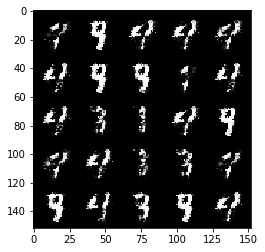

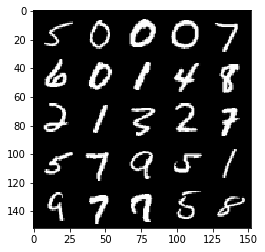

 90%|████████▉ | 420/469 [00:09<00:01, 41.54it/s]

Epoch 191, step 90000: Generator loss: 4.777473965644838, discriminator loss: 0.04935601683054124


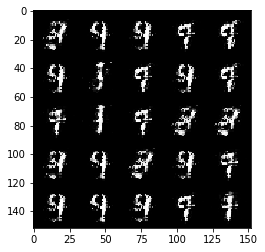

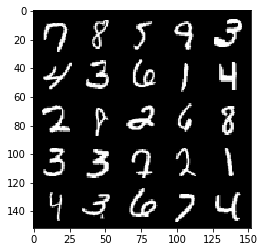

 96%|█████████▌| 449/469 [00:07<00:00, 60.42it/s]

Epoch 192, step 90500: Generator loss: 4.6451398720741235, discriminator loss: 0.05116430818289526


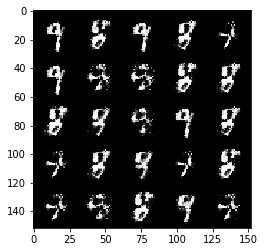

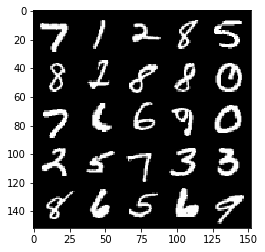

  3%|▎         | 14/469 [00:00<00:07, 60.69it/s]

Epoch 194, step 91000: Generator loss: 4.6247971034050055, discriminator loss: 0.05688530244678257


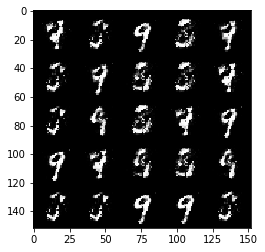

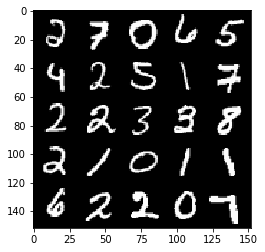

  9%|▊         | 40/469 [00:00<00:07, 59.36it/s]

Epoch 195, step 91500: Generator loss: 4.511169139385221, discriminator loss: 0.06300693832524124


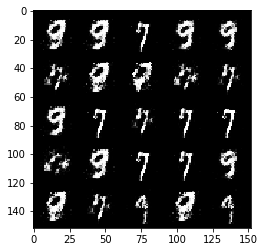

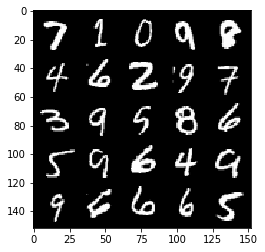

 16%|█▌        | 74/469 [00:01<00:07, 49.81it/s]

Epoch 196, step 92000: Generator loss: 4.392759699344639, discriminator loss: 0.06994950717128819


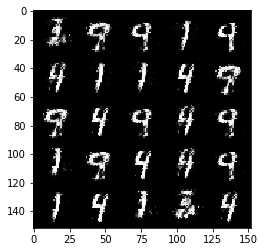

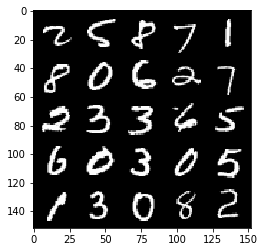

 22%|██▏       | 105/469 [00:02<00:07, 48.11it/s]

Epoch 197, step 92500: Generator loss: 4.139949097156524, discriminator loss: 0.07223382087238138


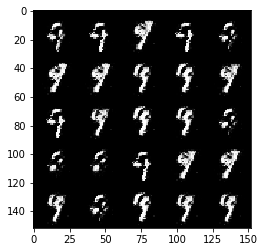

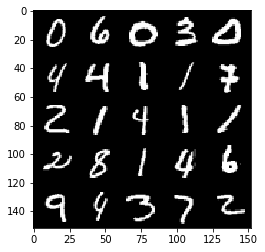

 29%|██▊       | 134/469 [00:02<00:07, 44.87it/s]

Epoch 198, step 93000: Generator loss: 3.870219120025631, discriminator loss: 0.08270583330839874


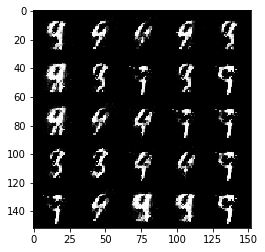

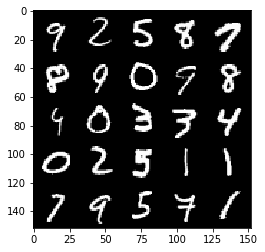

 35%|███▌      | 165/469 [00:03<00:07, 43.32it/s]

Epoch 199, step 93500: Generator loss: 3.8020494117736776, discriminator loss: 0.09123683548904953


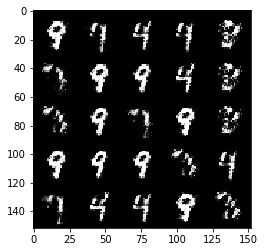

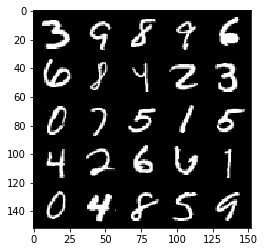

100%|██████████| 469/469 [00:10<00:00, 43.14it/s]


In [19]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: 

losses = {
    'epochs': [],
    'gen': [],
    'disc': []
}

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            losses['epochs'].append(epoch)
            losses['gen'].append(mean_generator_loss)
            losses['disc'].append(mean_discriminator_loss)
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


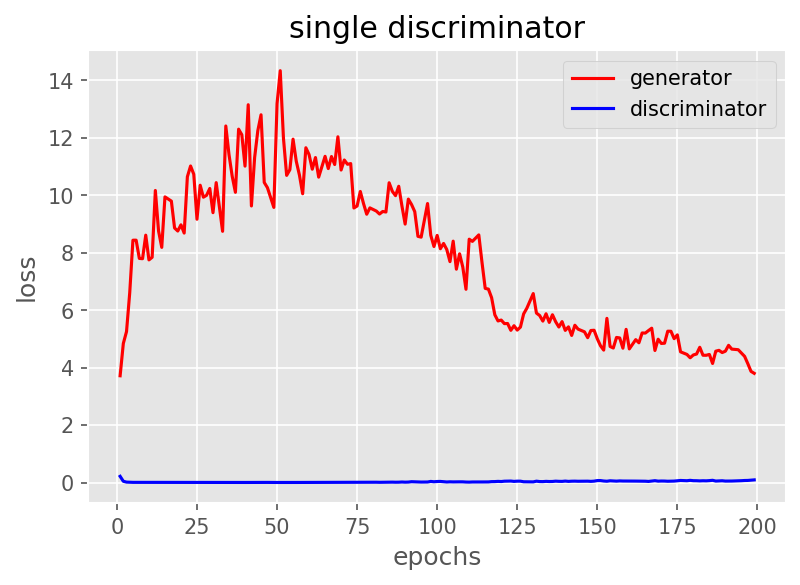

In [22]:
plt.style.use('ggplot')
plt.figure(dpi=150)
n = 200
x = losses['epochs'][:n]
plt.plot(x, losses['gen'][:n], 'r', label='generator')
plt.plot(x, losses['disc'][:n], 'b', label='discriminator')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('single discriminator')
# plt.ylim([0, 10])
plt.legend()